In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import importlib
from sklearn.preprocessing import LabelEncoder
from Data_Functions import Get_Data, Extract_Initial_Data, Clean_and_dropna
from Visualization_Functions import plot_corrs, get_ecdfplots, get_violinplots, plot_hists_by_Cryo_and_Transported
from Visualization_Functions import plot_ratios_by_Cryo_and_Transported, plot_CryoTrans_Counts
import string
%run Models.ipynb

In [2]:
filename = 'Data/train.csv'
df = Get_Data(filename)
df_test = Get_Data('data/test.csv')

df, df_test = Extract_Initial_Data(df, df_test)

In [3]:
df_clean, df_test_clean = Clean_and_dropna(df, df_test)

Number of null rows before cleaning:  3083
skewed_features:  ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'GroupSize', 'FamilySize', 'GroupFamilySize', 'CabinFamilySize', 'CabinGroupSize', 'CabinSize']
drop remaining 1371 null rows in training data
drop remaining 685 null rows in test data


# Closer look at the luxury features and Age

In [4]:
Features = ['CryoSleep', 'Spa', 'RoomService', 'VRDeck', 'FoodCourt', 'ShoppingMall', 'Age', 'Transported']
Luxury_Features = ['Spa', 'RoomService', 'VRDeck', 'FoodCourt', 'ShoppingMall']
Non_Essential_Lux_Features = ['RoomService', 'Spa', 'VRDeck']
Essential_Lux_Features = ['FoodCourt', 'ShoppingMall']
df0 = df_clean[Features].copy(deep = True)
df0['Transported'] = df0['Transported'].astype(int)
df0['Lux_non_Essential'] = df0[Non_Essential_Lux_Features].mean(axis = 1)
df0['Lux_Essential'] = df0[Essential_Lux_Features].mean(axis = 1)

In [5]:
bins = 10
bin_labels = range(1, bins + 1)
df0['Age_Bin'], Bin_ranges = pd.qcut(df0.Age, q = bins, labels = bin_labels, retbins = True)
Bin_ranges

array([ 0., 12., 18., 21., 24., 27., 30., 35., 41., 49., 79.])

### First, let's look at the correlations

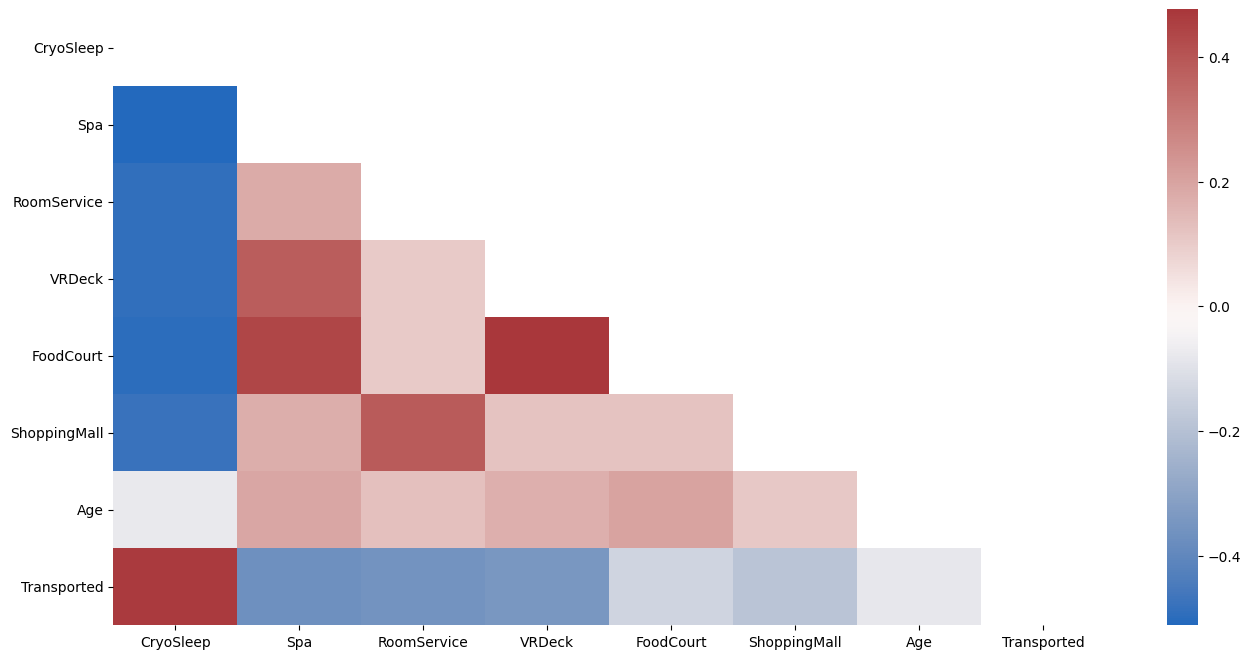

In [6]:
plot_corrs(df0[Features], cmap = 'vlag')

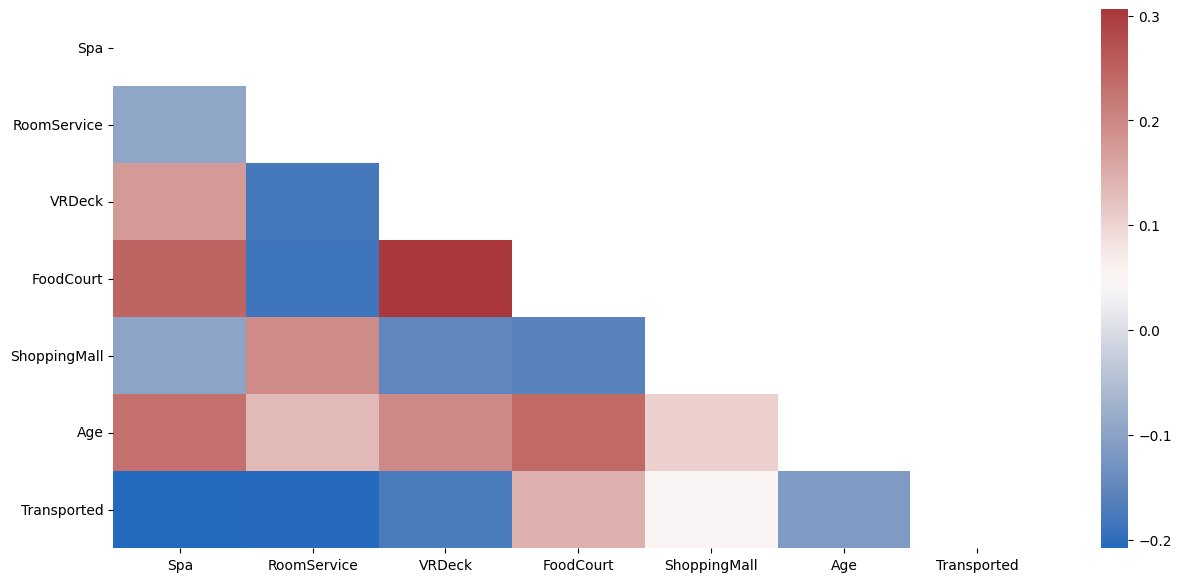

In [7]:
plot_corrs(df0[df0.CryoSleep == False][Luxury_Features + ['Age', 'Transported']], cmap = 'vlag')

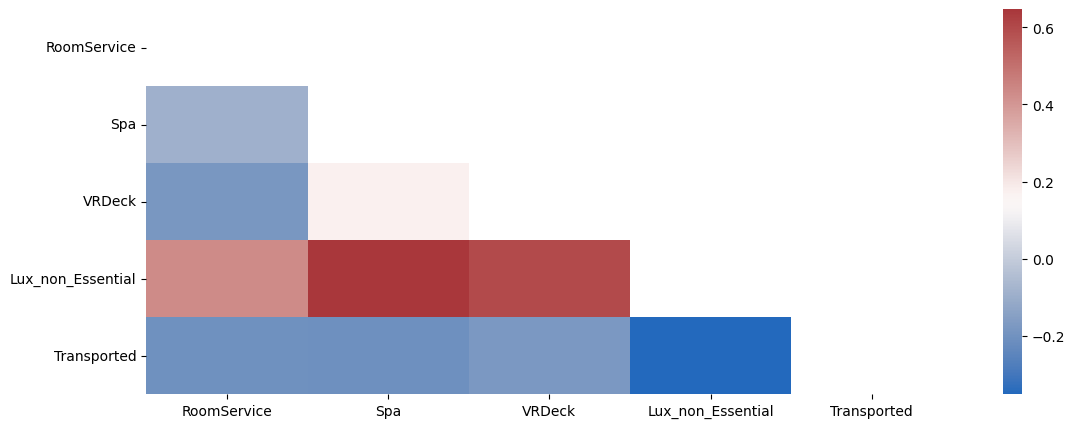

In [8]:
plot_corrs(df0[df0.CryoSleep == False][Non_Essential_Lux_Features + ['Lux_non_Essential', 'Transported']], cmap = 'vlag')

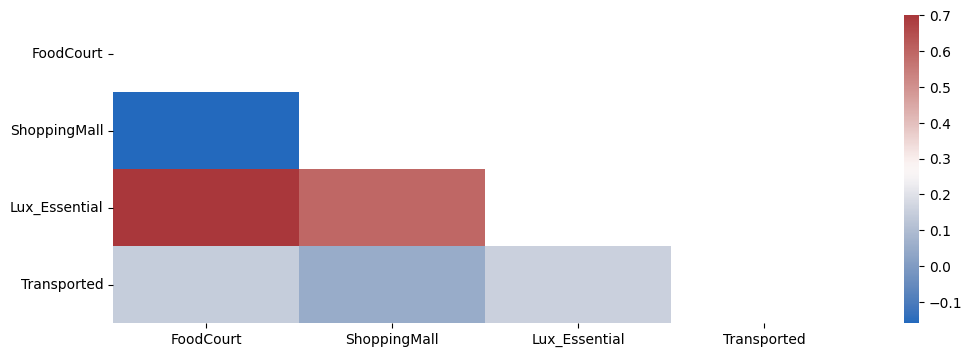

In [9]:
plot_corrs(df0[df0.CryoSleep == False][Essential_Lux_Features + ['Lux_Essential', 'Transported']], cmap = 'vlag')

### Examine distributions, ratios, and histograms

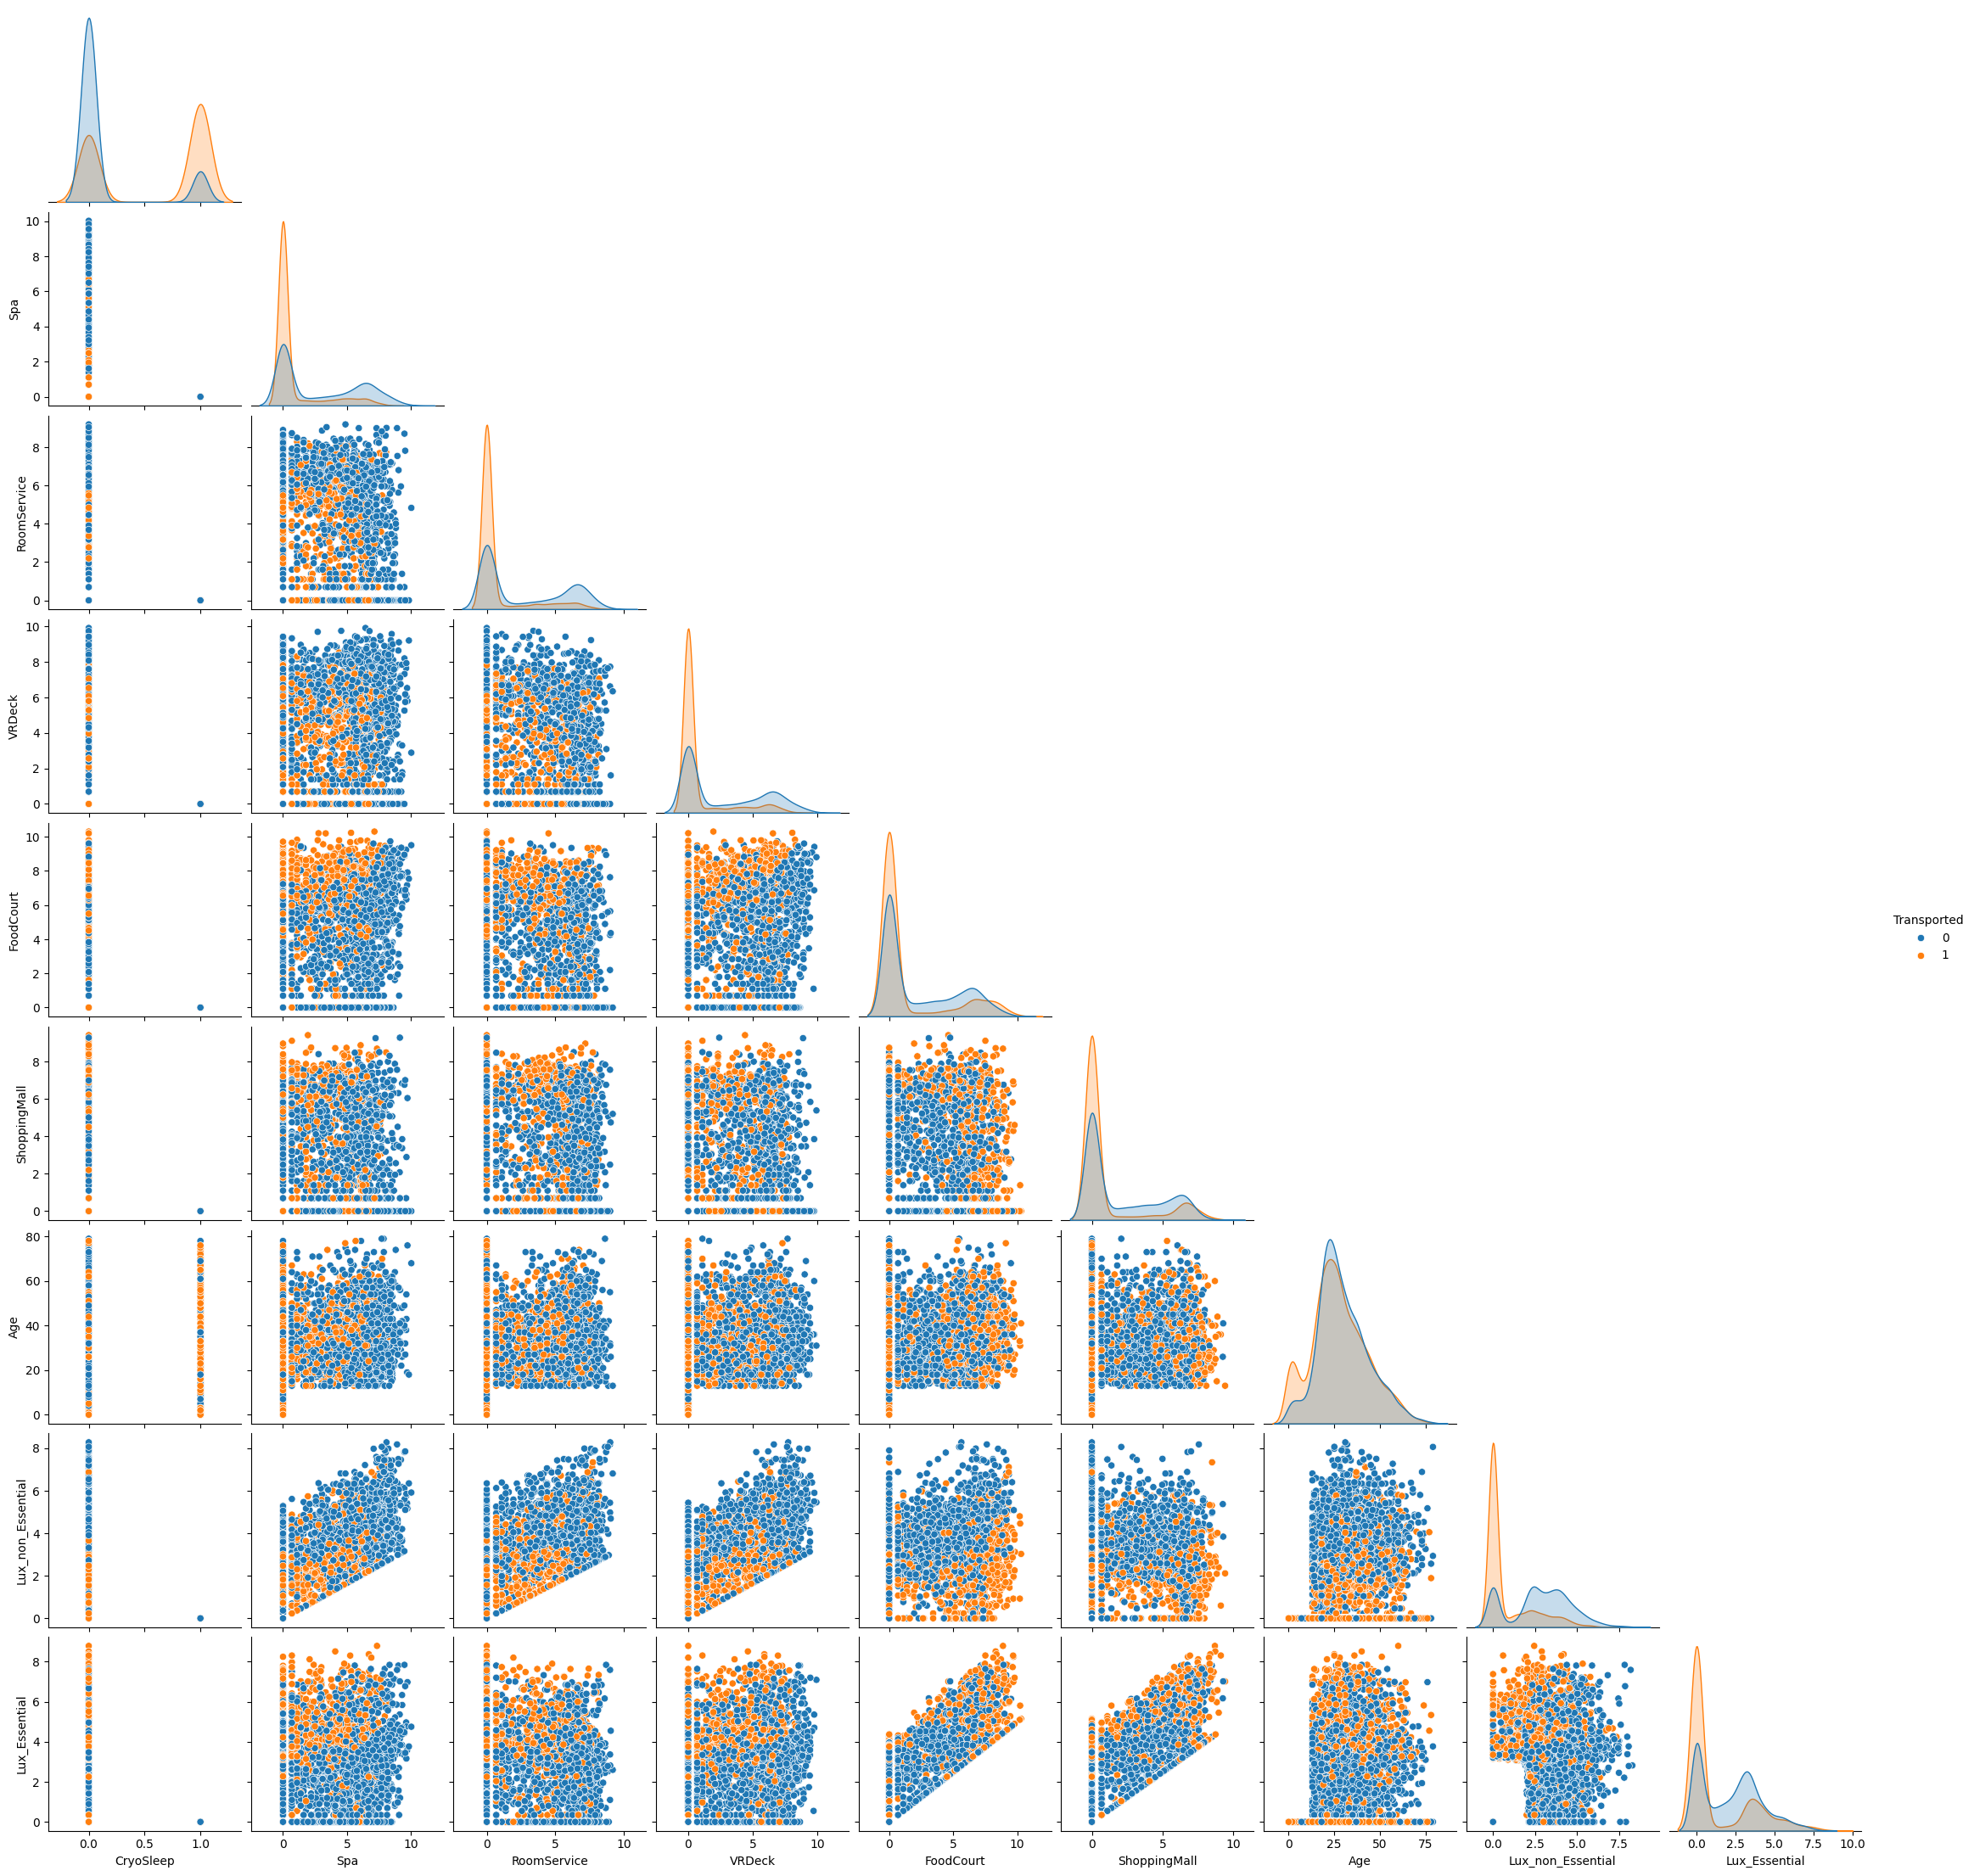

In [10]:
sns.pairplot(data = df0, hue = 'Transported', corner = True)

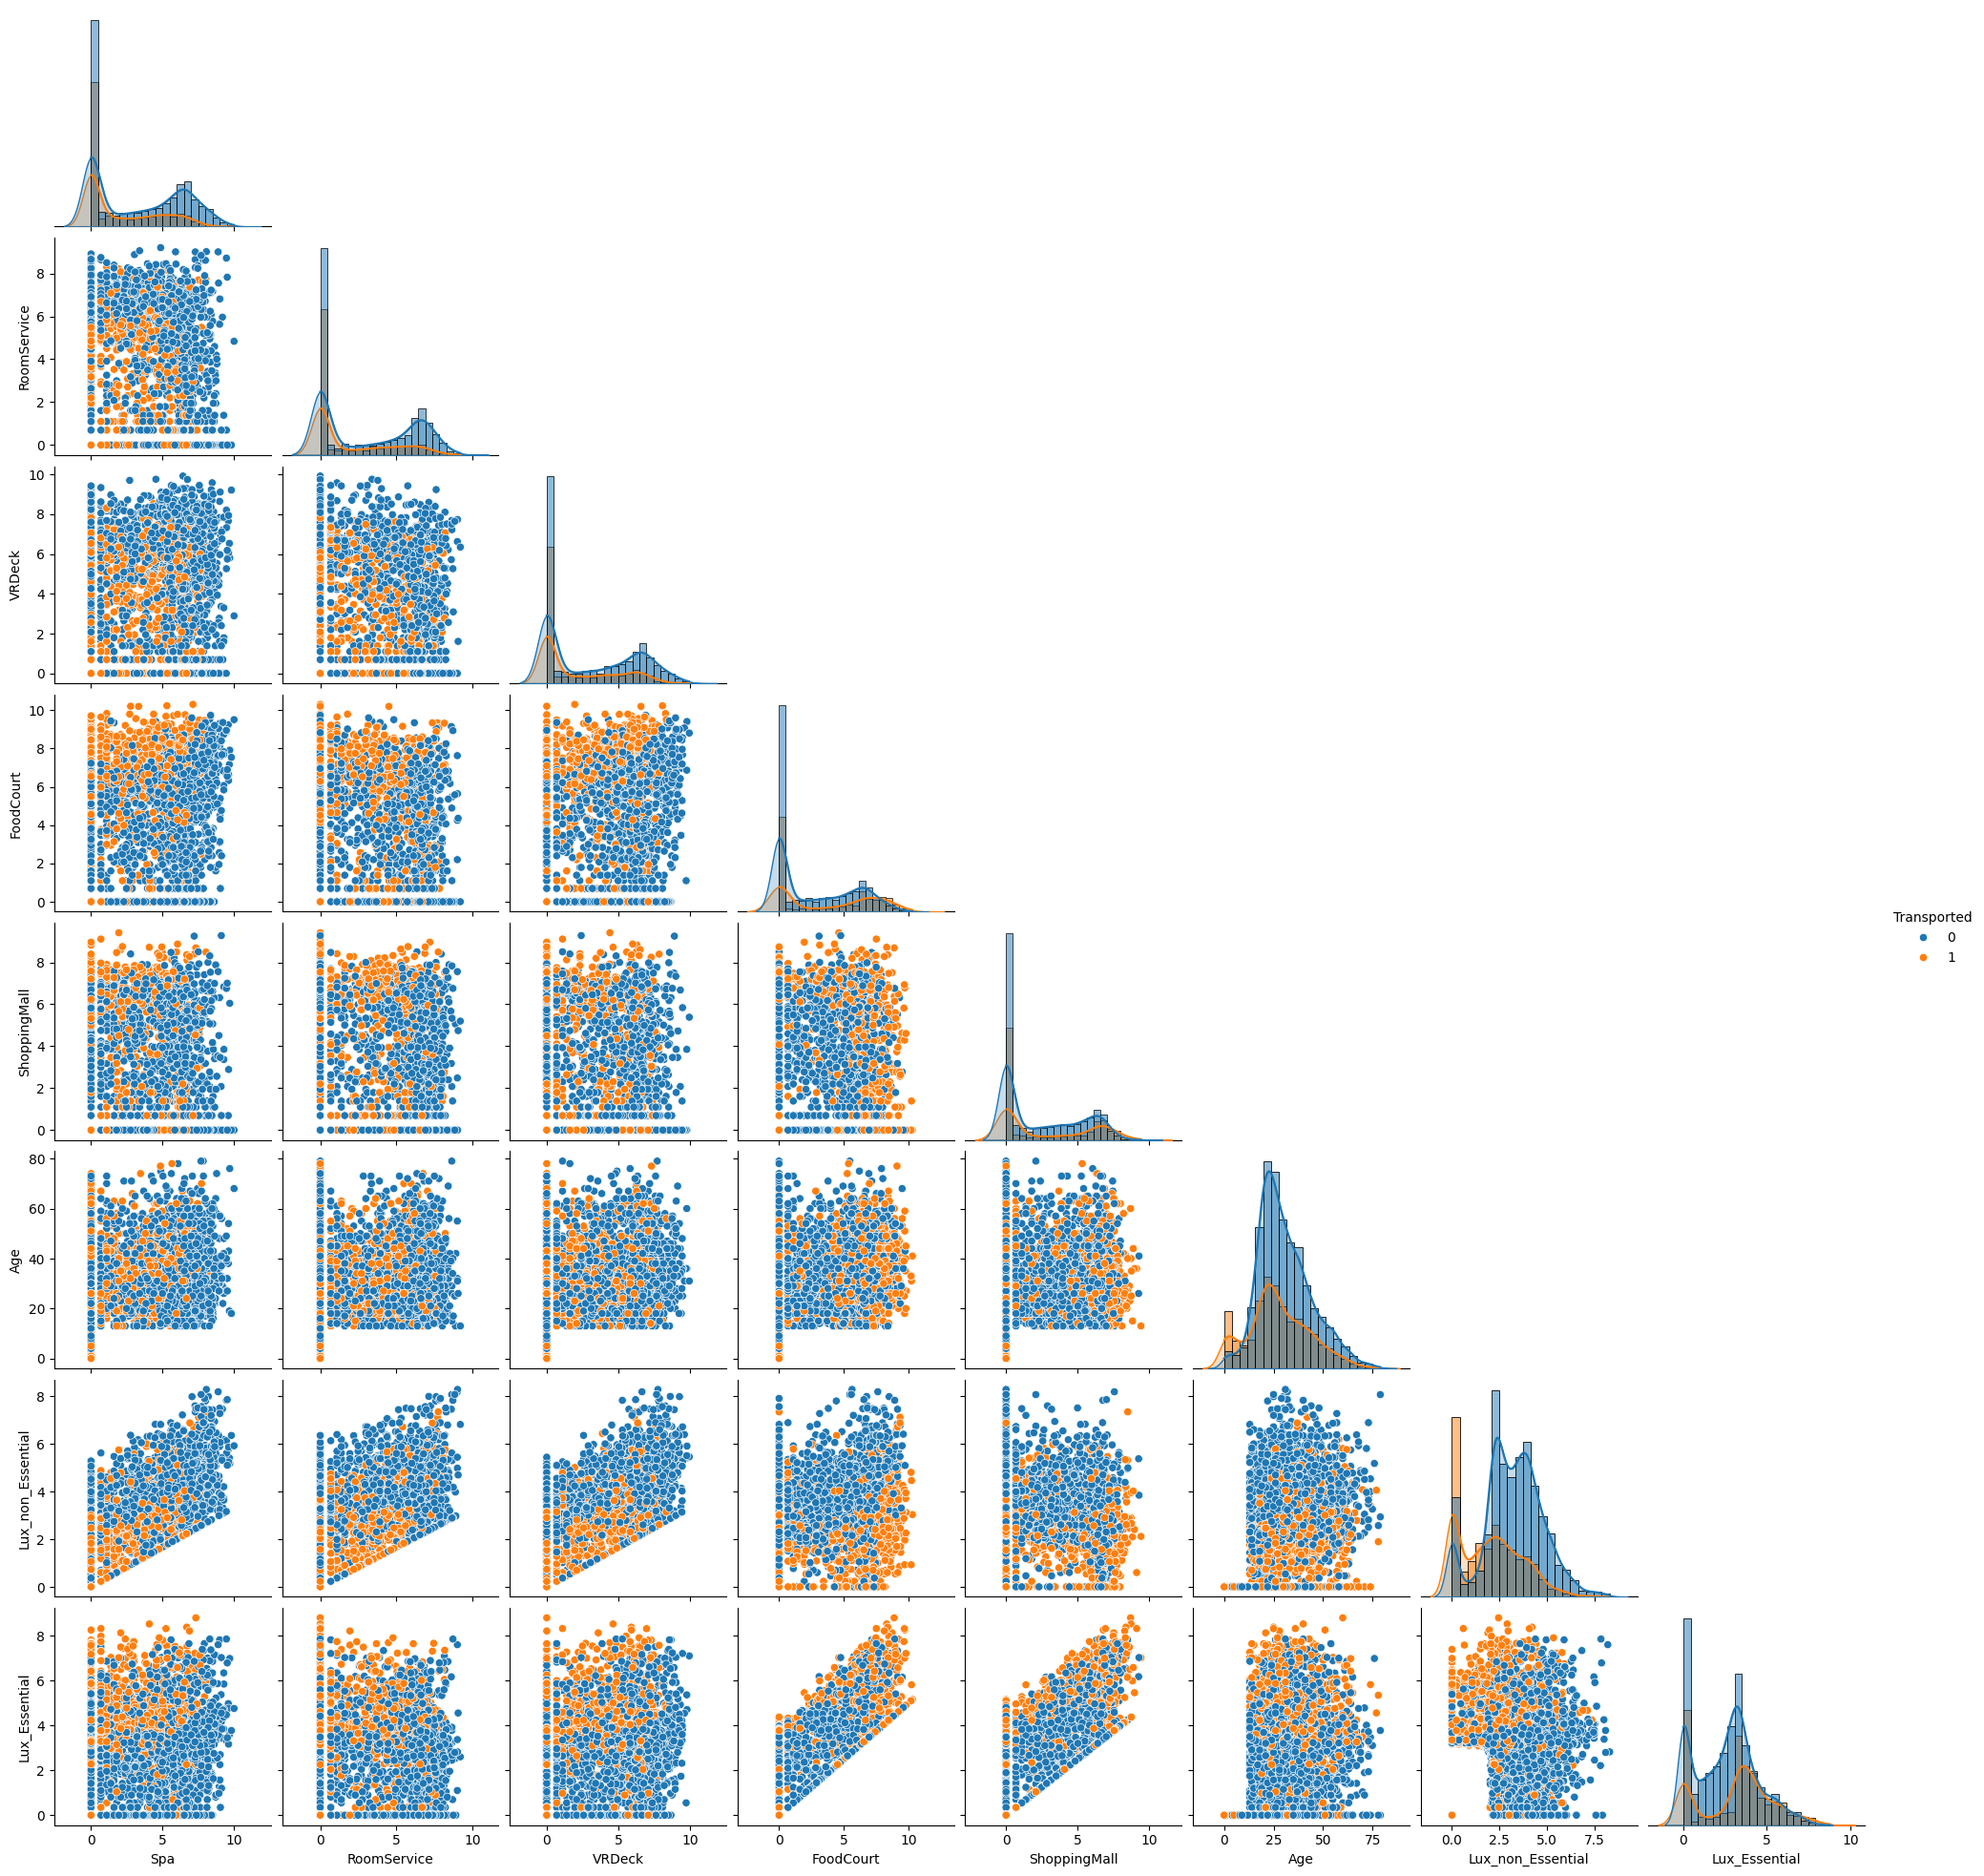

In [11]:
mask = df0['CryoSleep'] == 0
g = sns.pairplot(data = df0[mask].drop(columns = ['CryoSleep']), hue = 'Transported', corner = True)
g.map_diag(sns.histplot, kde = True, stat = 'density', bins = 20)

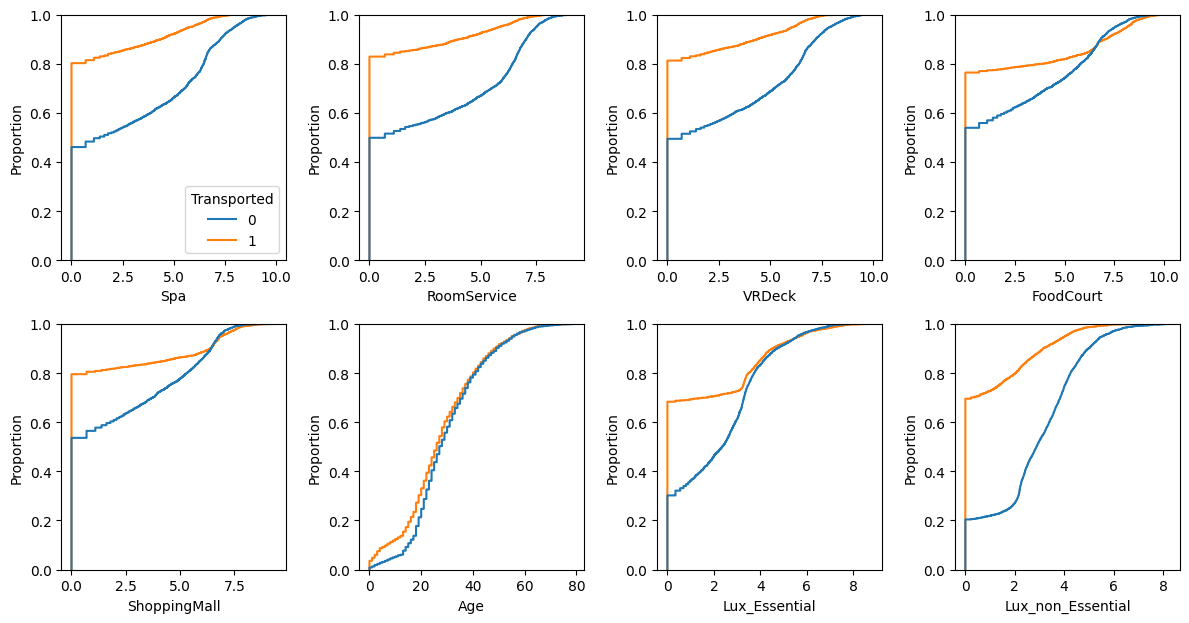

In [12]:
vars_list = Luxury_Features + ['Age', 'Lux_Essential', 'Lux_non_Essential']
get_ecdfplots(df0, vars_list, target = 'Transported', ncols = 4)

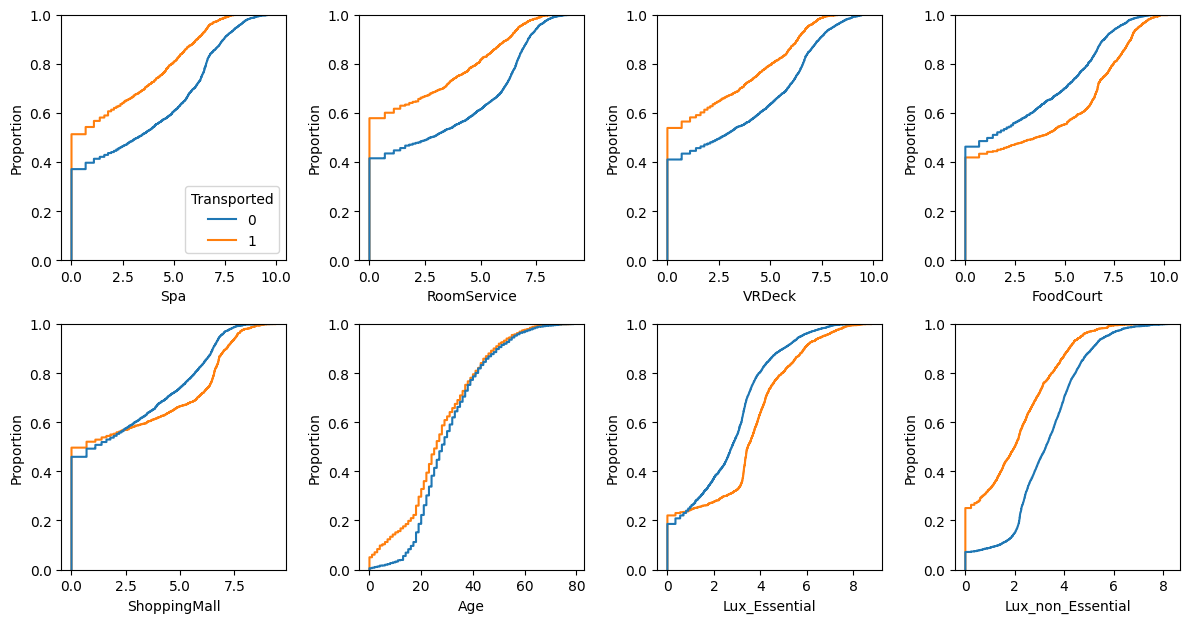

In [13]:
mask = df0['CryoSleep'] == 0
get_ecdfplots(df0[mask], vars_list, target = 'Transported', ncols = 4)

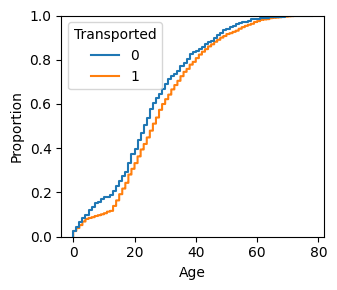

In [14]:
mask = df0['CryoSleep'] == 1
get_ecdfplots(df0[mask], ['Age'], target = 'Transported', ncols = 3)

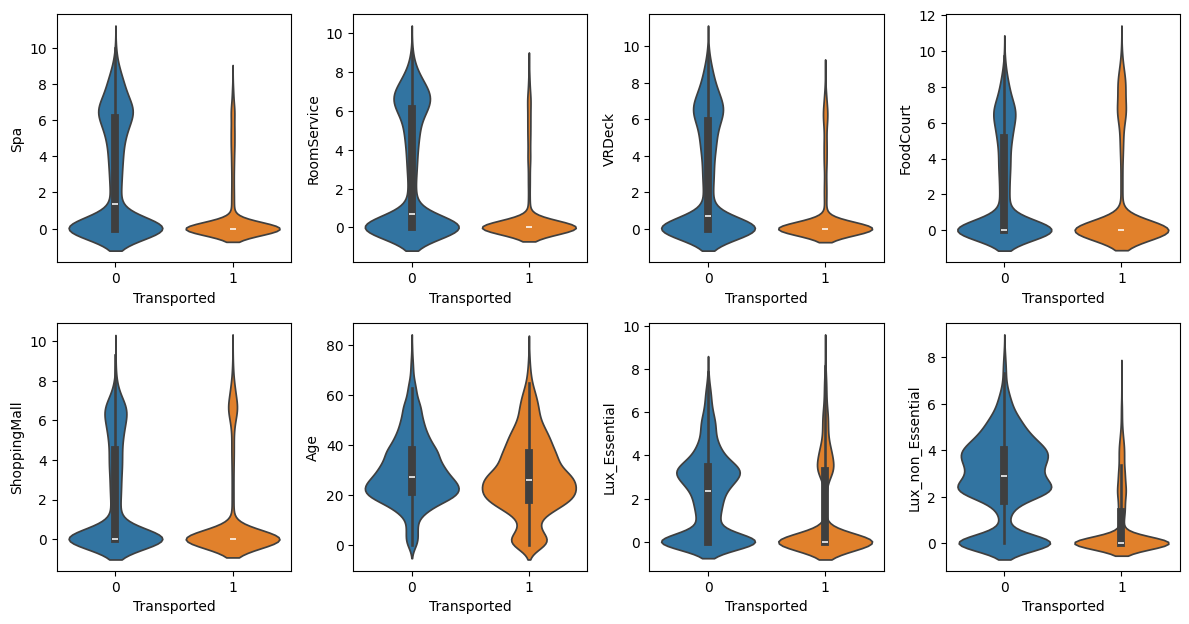

In [15]:
df01 = df0.copy()
df01['CryoSleep'] = df01['CryoSleep'].astype(bool).astype(str)
df01['Transported'] = df01['Transported'].astype(str)
get_violinplots(df01, vars_list, target1 = 'Transported', ncols = 4)

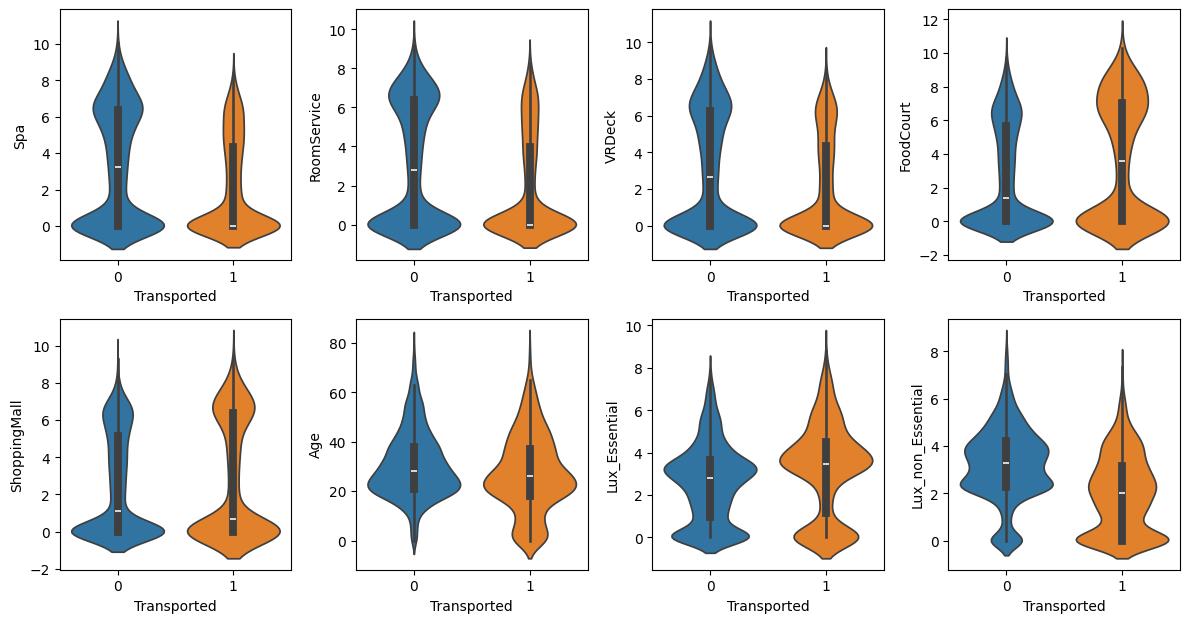

In [16]:
get_violinplots(df01[df01['CryoSleep'] == 'False'], vars_list, target1 = 'Transported', ncols = 4)

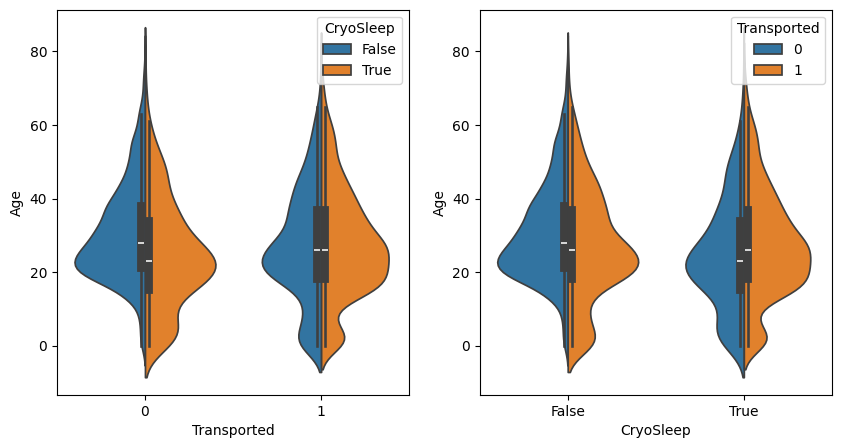

In [17]:
get_violinplots(df01, ['Age'], target1 = 'Transported', ncols = 1, target2 = 'CryoSleep')

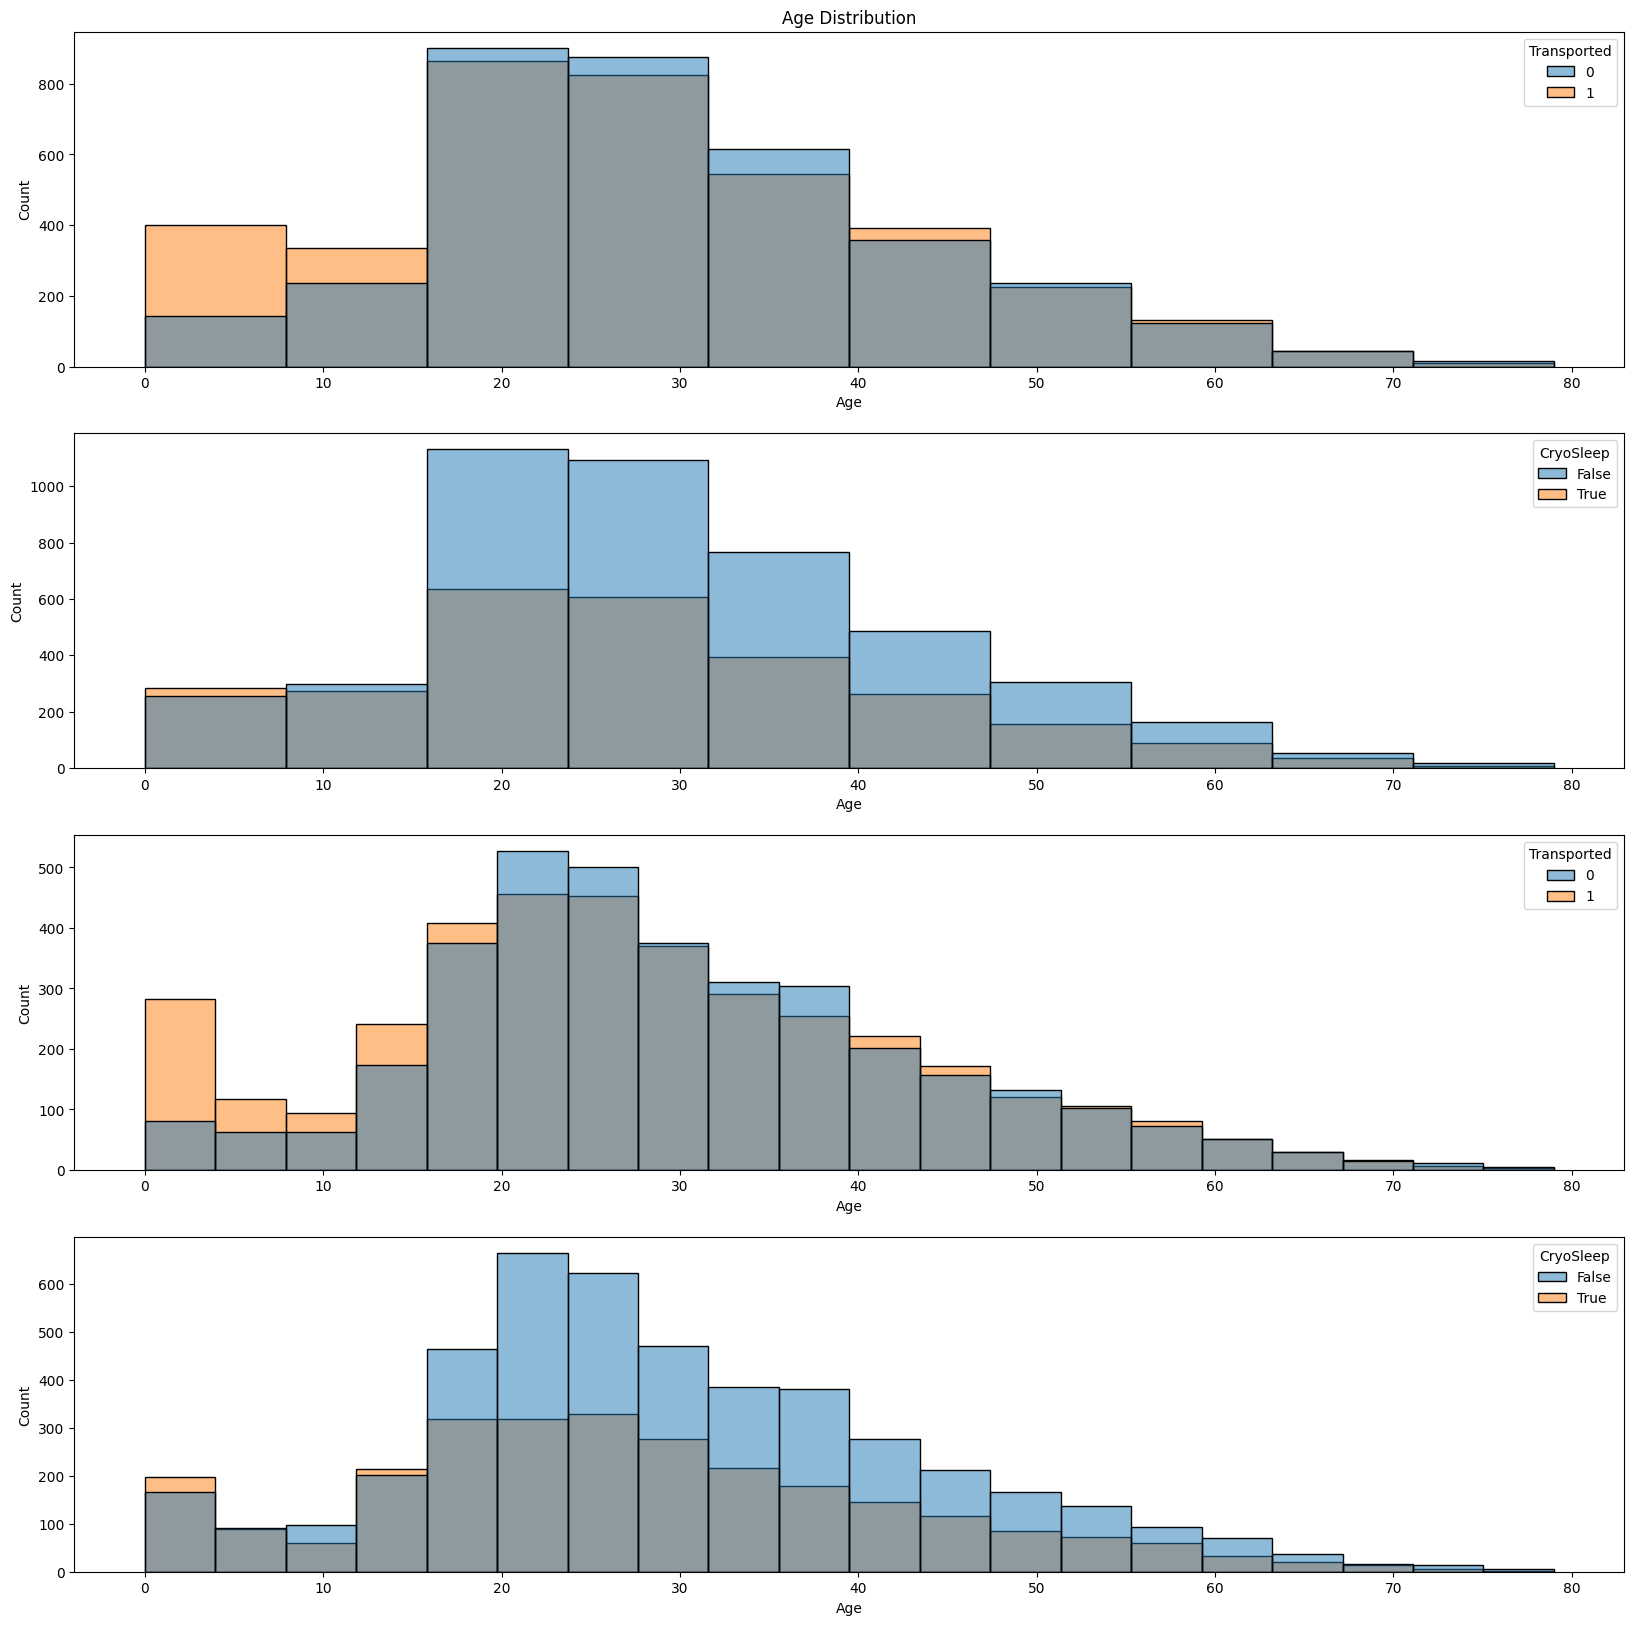

In [18]:
plot_hists_by_Cryo_and_Transported(df0, 'Age')

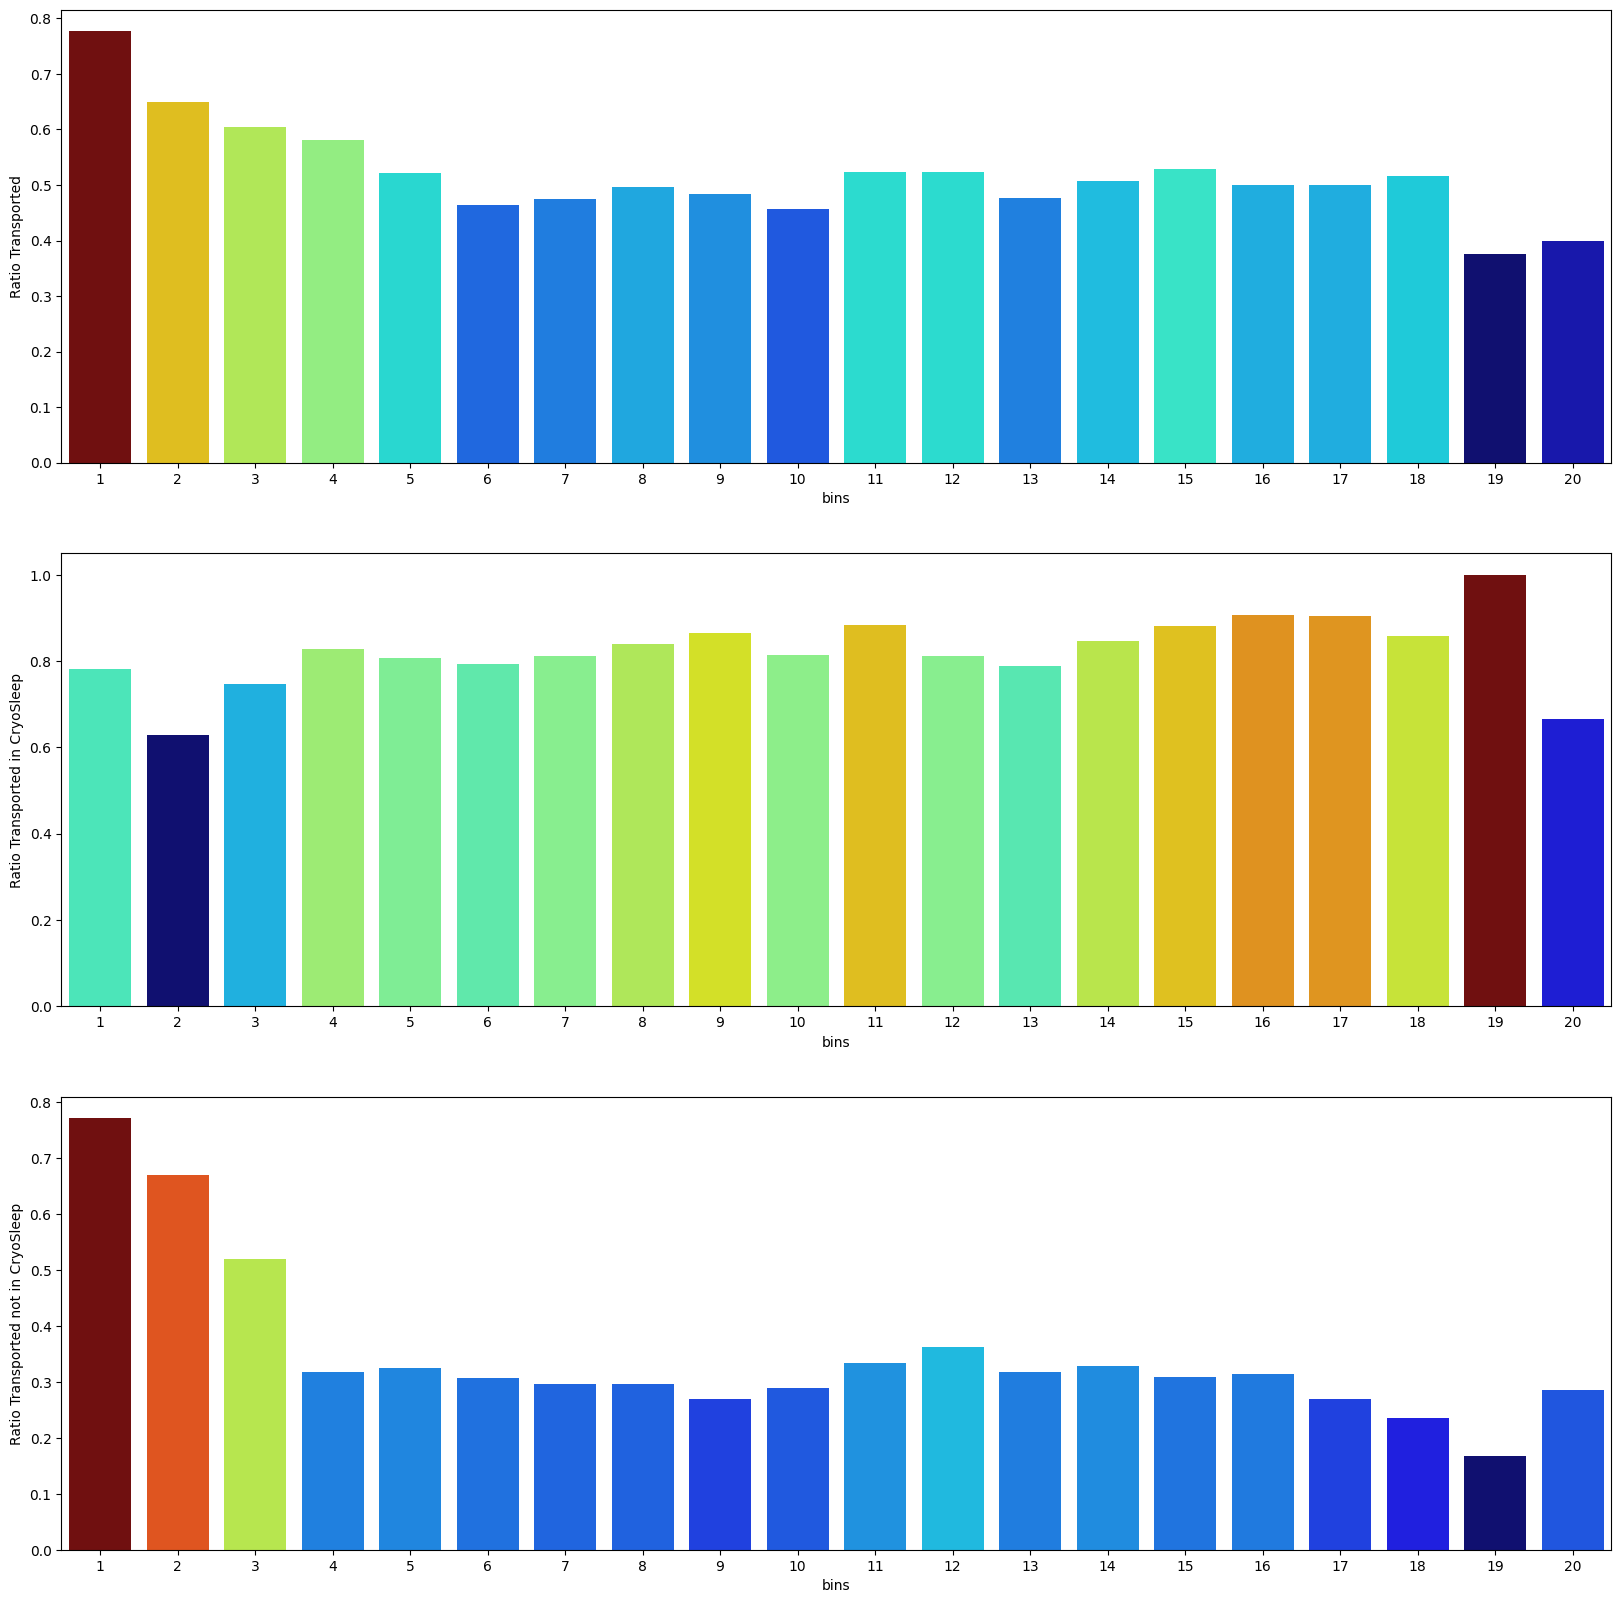

In [19]:
bin_ranges, df_num_groups = plot_ratios_by_Cryo_and_Transported(df0, 'Age', nbins = 20)

In [20]:
str(bin_ranges)

'[(0.0, 4.0), (4.0, 7.9), (7.9, 11.9), (11.9, 15.8), (15.8, 19.8), (19.8, 23.7), (23.7, 27.6), (27.6, 31.6), (31.6, 35.6), (35.6, 39.5), (39.5, 43.4), (43.4, 47.4), (47.4, 51.4), (51.4, 55.3), (55.3, 59.2), (59.2, 63.2), (63.2, 67.2), (67.2, 71.1), (71.1, 75.0), (75.0, 79.0)]'

In [21]:
# _, _ = plot_ratios_by_Cryo_and_Transported(df0, 'Age_Bin', nbins = bins, cat = True)

In [22]:
# mapping_age = {1: 'Child', 2: 'teen', 3: '19-21', 4: 'low 20s', 5: '25-27', 6: '28-30', 7: 'low 30s', 8: '36-41', 9: '42-49', 10: '50 and above'}
# df0['Age_Brackets'] = df0['Age_Bin'].map(mapping_age)

bin_edges = [0, 2, 5, 13, 20, 36, 46, 65, 90]
LifeStages_choices = ['Infant', 'Toddler', 'Child', 'Teen', 'Young Adult', 'Young middle aged', 'Older middle aged', 'Senior']
LifeStages_conds = [df0.Age.between(bin_edges[i], bin_edges[i + 1] - 0.1) for i in range(len(bin_edges) - 1)]

Brackets_choices = ['Child', 'Teen', '19-21', 'Low 20s', '25-27', '28-30', 'Low 30s', '36-41', '42-49', '50 and above']
Brackets_conds = [df0.Age_Bin == i for i in range(1, len(Brackets_choices) + 1)]

df0['Age_LifeStages'] = np.select(LifeStages_conds, LifeStages_choices)
df0['Age_Brackets'] = np.select(Brackets_conds, Brackets_choices)

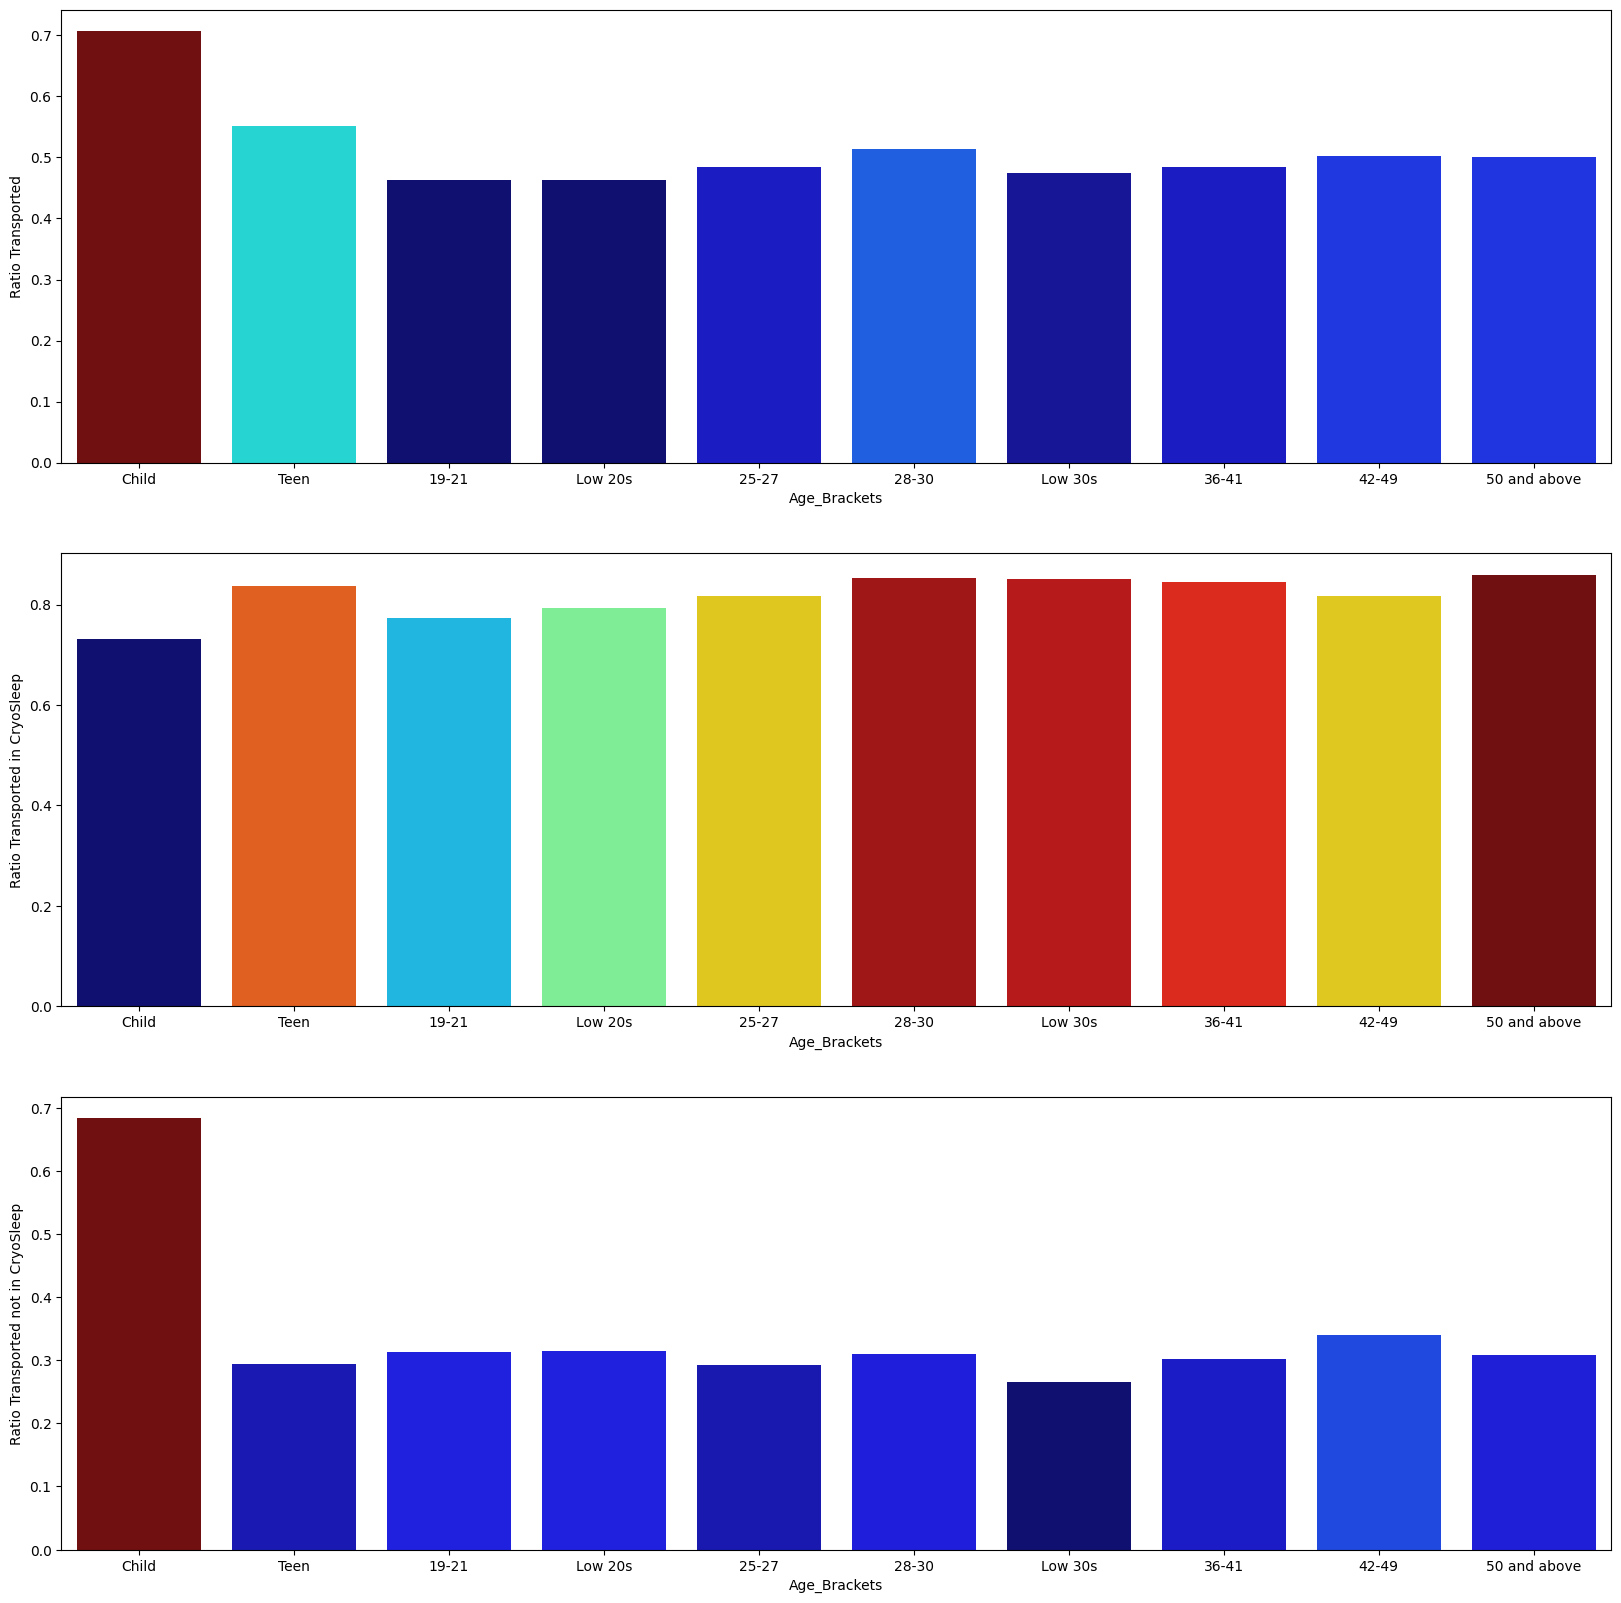

In [23]:
_, _ = plot_ratios_by_Cryo_and_Transported(df0, 'Age_Brackets', nbins = bins, cat = True, cat_bins = Brackets_choices)

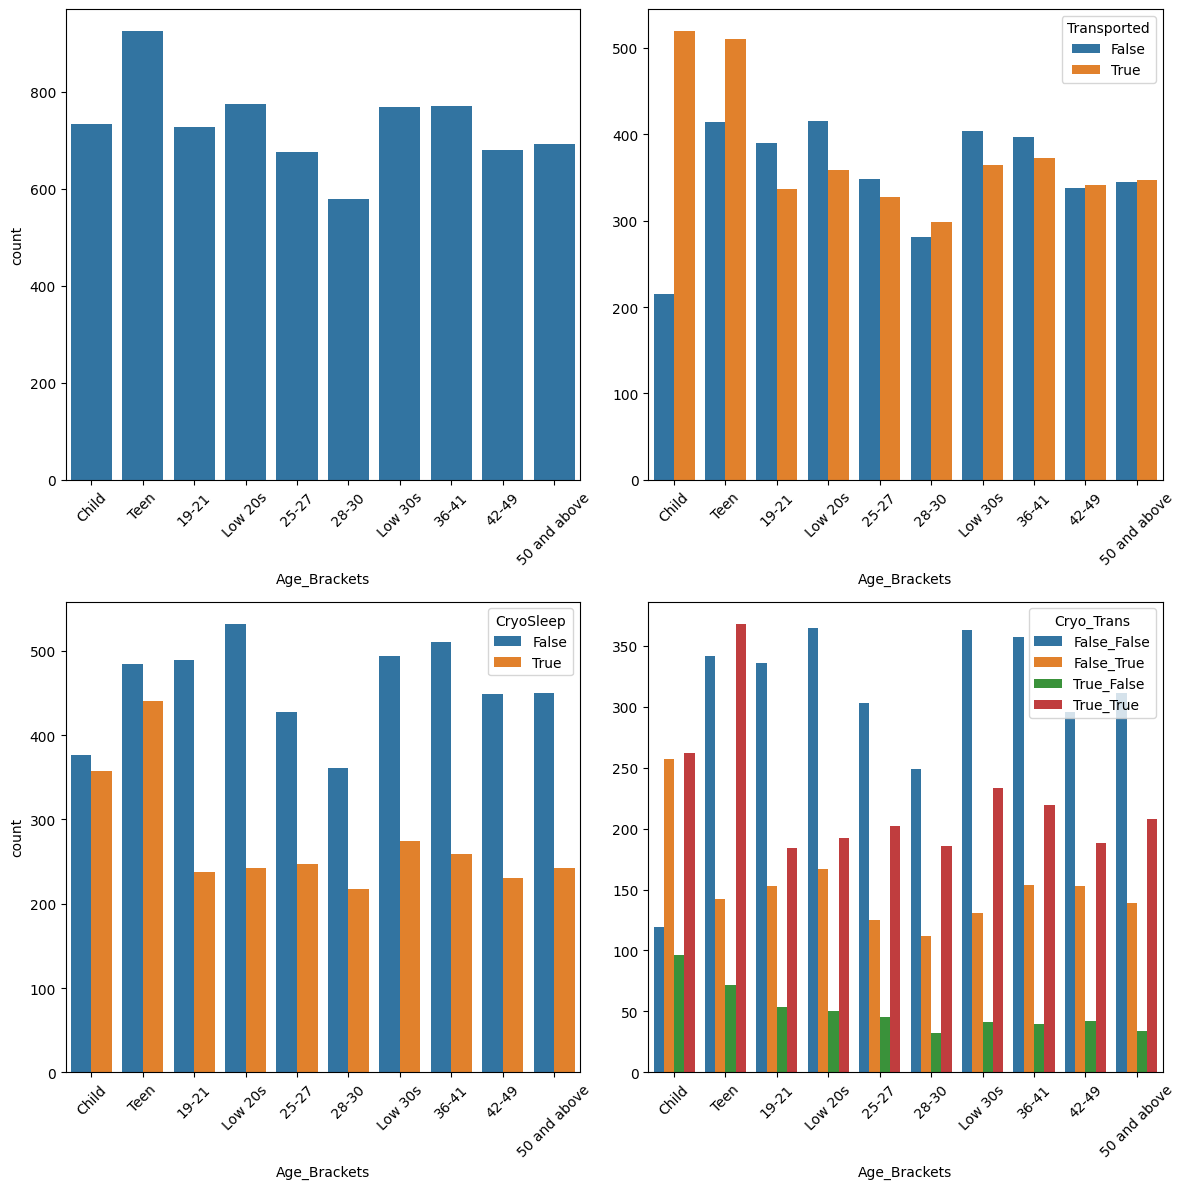

In [24]:
plot_CryoTrans_Counts(df0, 'Age_Brackets', Brackets_choices)

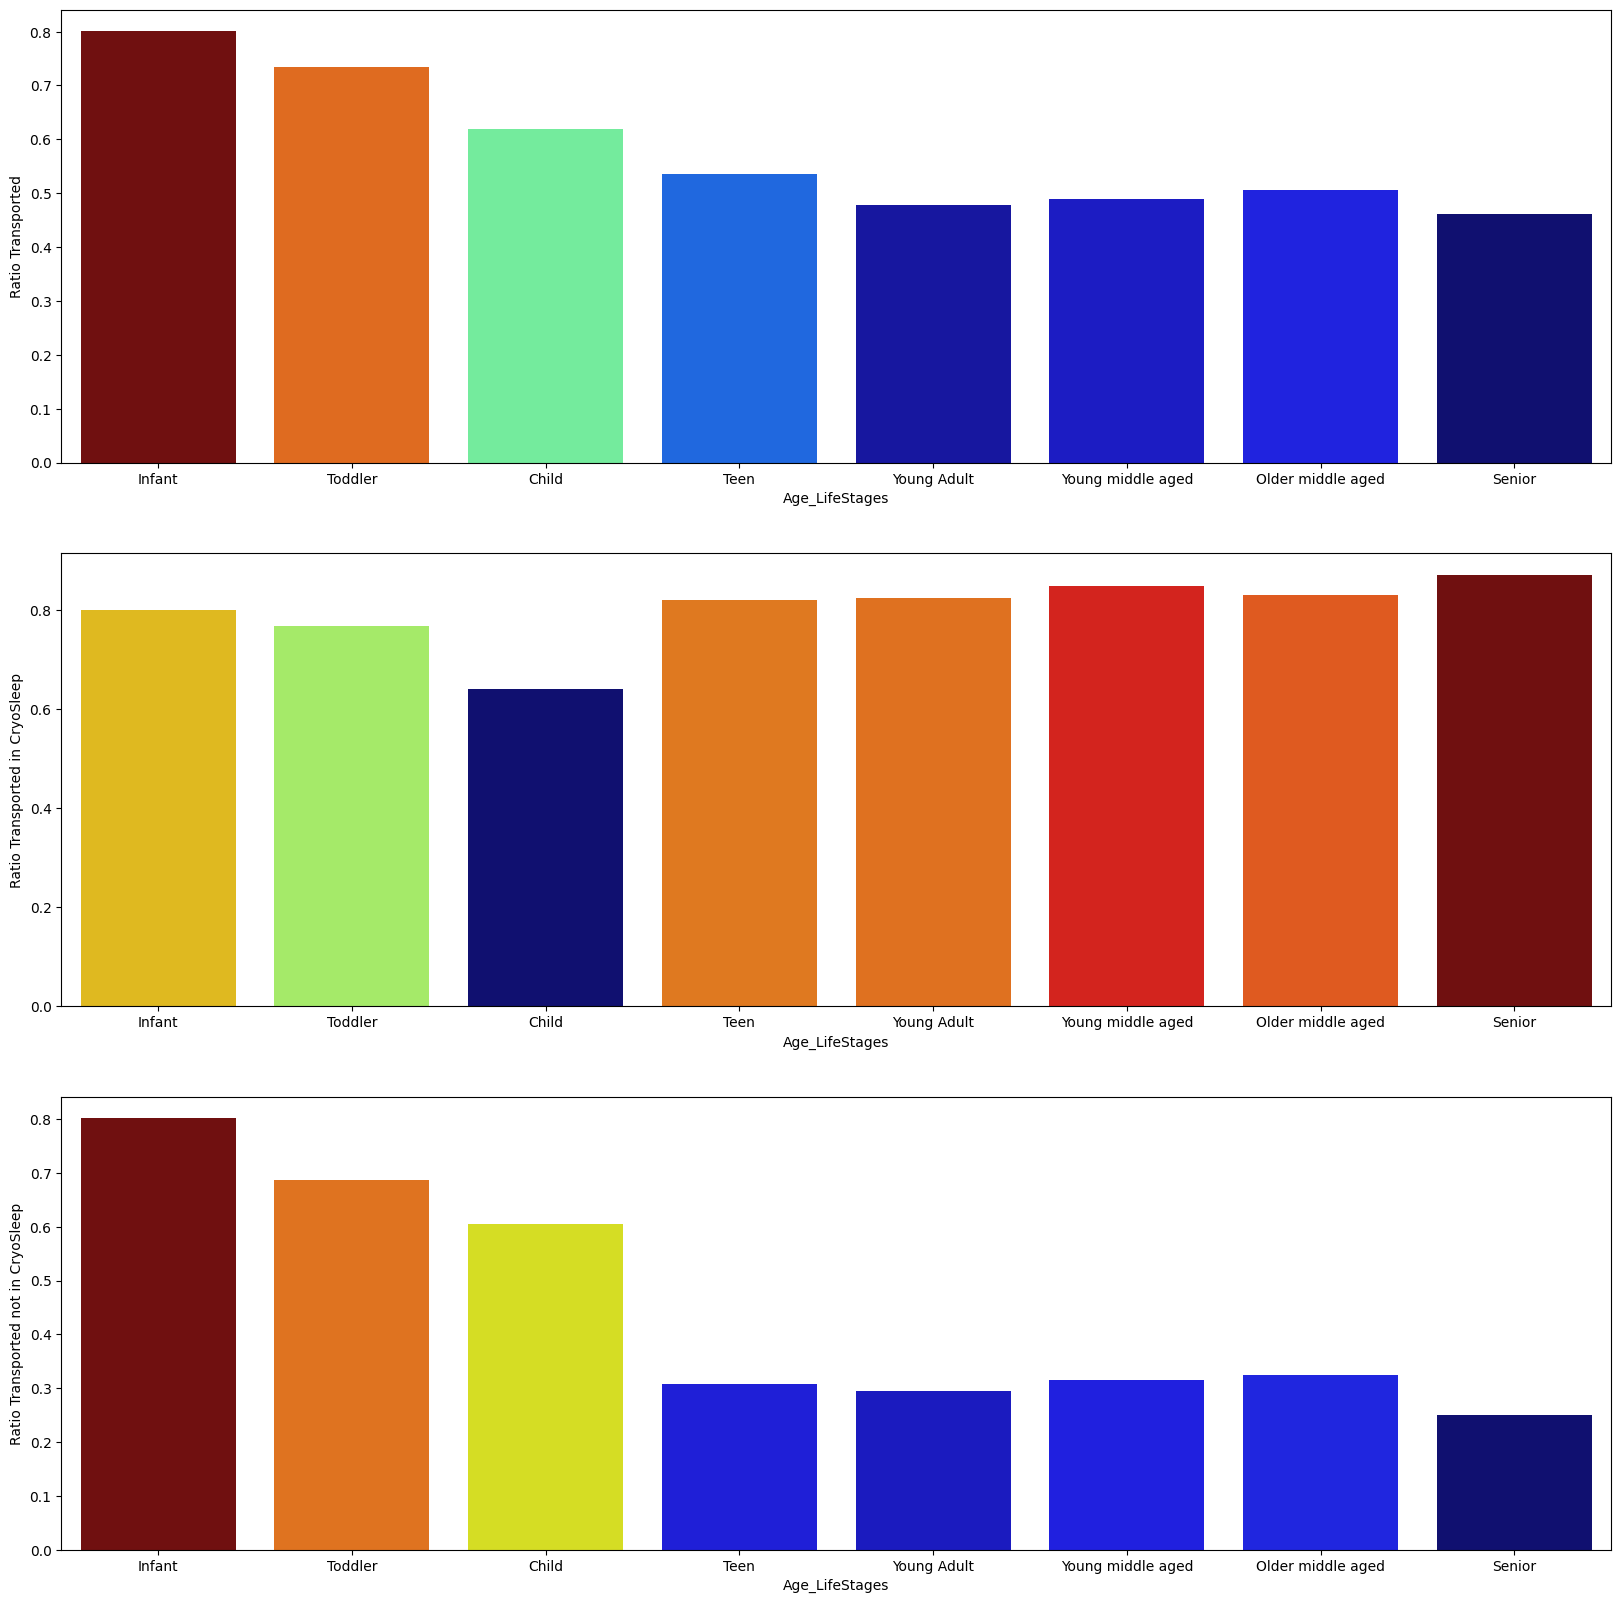

In [25]:
_, _ = plot_ratios_by_Cryo_and_Transported(df0, 'Age_LifeStages', nbins = bins, cat = True, cat_bins = LifeStages_choices)

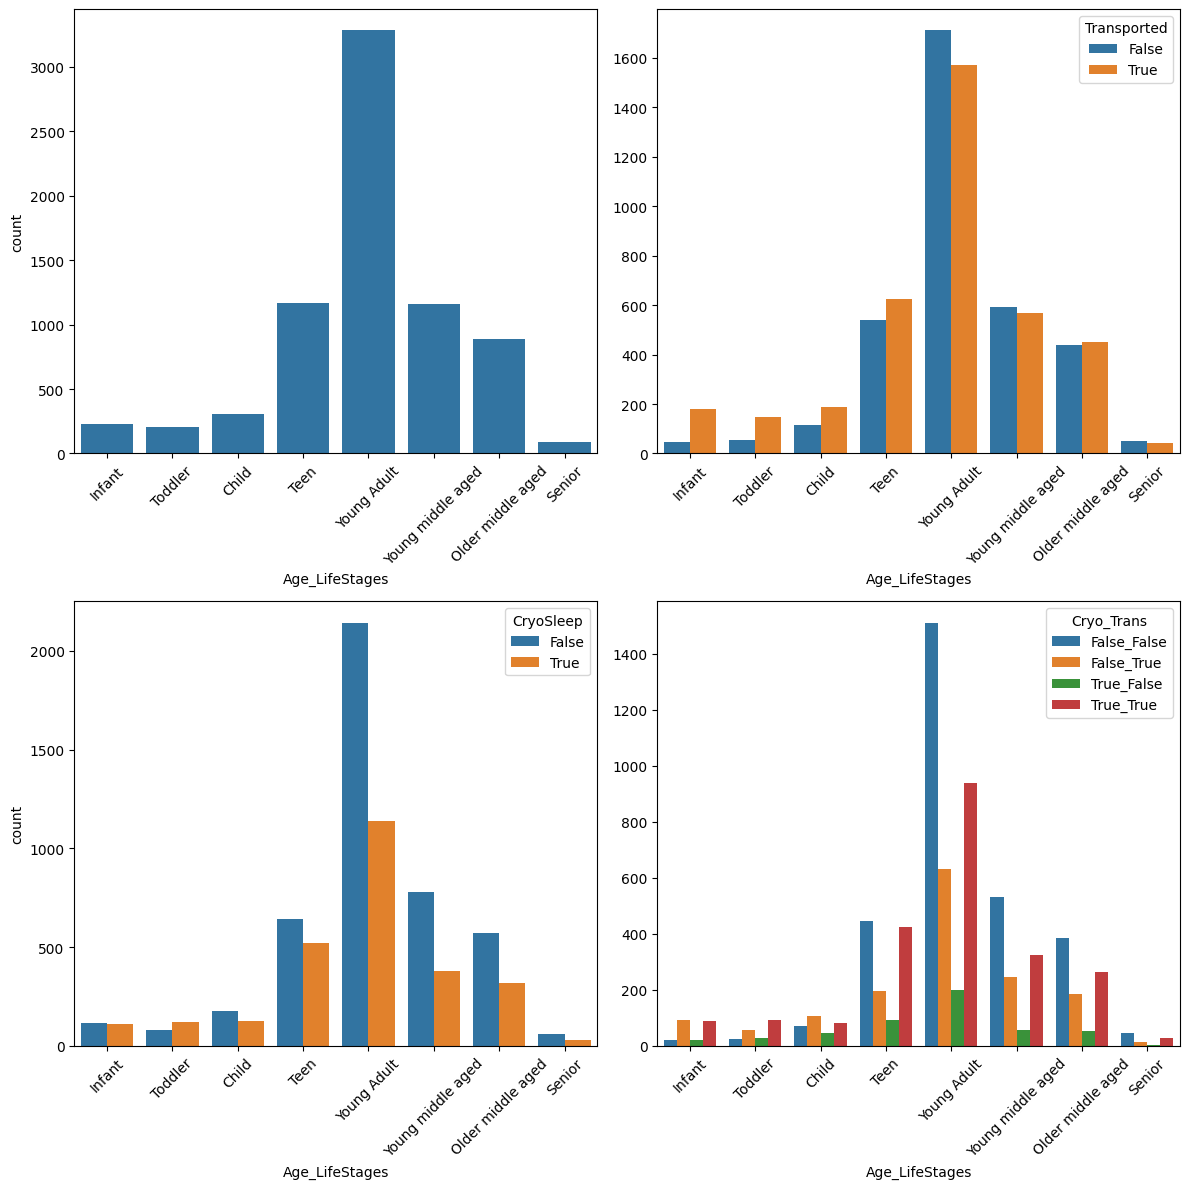

In [26]:
plot_CryoTrans_Counts(df0, 'Age_LifeStages', LifeStages_choices)

### Observations
* Passengers that spend very little or none on Luxury items are more likely to be transported
* However, passengers in CryoSleep are more likely to be transported and of course, cannot be using any of the luxury items.
* Correcting for CryoSleep, we see that among passengers not in Cryosleep, those that spend little in Spa, RoomSevice, and VRDeck are more likely to be transported compared to big spenders. However, it is the opposite for FoodCourt and ShoppingMall
* Among under age passengers that were not transported, they are a lot more likely to be in Cryosleep. In other words, young passengers that are not in Cryosleep are more likely to transported.
* There is a stronger correlation between being transported and the average of "non-essential luxury". Averaging "essential luxury" (FoodCourt and ShoppingMall) doesn't have the same effect

### Now, let's examine the effect of these features on few ML algorithms
The reported score below is the kfold accuracy score

In [27]:
df0.CryoSleep = df0.CryoSleep.astype(int)
df0.Transported = df0.Transported.astype(int)

In [28]:
basic_list = ['CryoSleep']
features_list = ['Spa', 'RoomService', 'VRDeck', 'FoodCourt', 'ShoppingMall', 'Age']
Compare_Ordered_Feature_Lists(df0, 'Transported', basic_list, features_list, Kfold = 10)

List0:  ['CryoSleep']
List1:  ['CryoSleep', 'Spa']
List2:  ['CryoSleep', 'Spa', 'RoomService']
List3:  ['CryoSleep', 'Spa', 'RoomService', 'VRDeck']
List4:  ['CryoSleep', 'Spa', 'RoomService', 'VRDeck', 'FoodCourt']
List5:  ['CryoSleep', 'Spa', 'RoomService', 'VRDeck', 'FoodCourt', 'ShoppingMall']
List6:  ['CryoSleep', 'Spa', 'RoomService', 'VRDeck', 'FoodCourt', 'ShoppingMall', 'Age']


In [29]:
basic_list = ['CryoSleep']
features_list = ['Lux_non_Essential', 'Lux_Essential', 'Age']
Compare_Ordered_Feature_Lists(df0, 'Transported', basic_list, features_list, Kfold = 10)

List0:  ['CryoSleep']
List1:  ['CryoSleep', 'Lux_non_Essential']
List2:  ['CryoSleep', 'Lux_non_Essential', 'Lux_Essential']
List3:  ['CryoSleep', 'Lux_non_Essential', 'Lux_Essential', 'Age']


In [30]:
basic_list = ['CryoSleep']
features_list = ['Lux_non_Essential', 'FoodCourt', 'ShoppingMall', 'Age']
Compare_Ordered_Feature_Lists(df0, 'Transported', basic_list, features_list, Kfold = 10)

List0:  ['CryoSleep']
List1:  ['CryoSleep', 'Lux_non_Essential']
List2:  ['CryoSleep', 'Lux_non_Essential', 'FoodCourt']
List3:  ['CryoSleep', 'Lux_non_Essential', 'FoodCourt', 'ShoppingMall']
List4:  ['CryoSleep', 'Lux_non_Essential', 'FoodCourt', 'ShoppingMall', 'Age']


In [31]:
basic_list = ['CryoSleep', 'VRDeck']
features_list = ['Lux_non_Essential', 'FoodCourt', 'ShoppingMall', 'Age']
Compare_Ordered_Feature_Lists(df0, 'Transported', basic_list, features_list, Kfold = 10)

List0:  ['CryoSleep', 'VRDeck']
List1:  ['CryoSleep', 'VRDeck', 'Lux_non_Essential']
List2:  ['CryoSleep', 'VRDeck', 'Lux_non_Essential', 'FoodCourt']
List3:  ['CryoSleep', 'VRDeck', 'Lux_non_Essential', 'FoodCourt', 'ShoppingMall']
List4:  ['CryoSleep', 'VRDeck', 'Lux_non_Essential', 'FoodCourt', 'ShoppingMall', 'Age']


In [32]:
basic_list = ['CryoSleep']
features_list = ['Age', 'ShoppingMall', 'FoodCourt', 'VRDeck', 'RoomService', 'Spa']
Compare_Ordered_Feature_Lists(df0, 'Transported', basic_list, features_list, Kfold = 10)

List0:  ['CryoSleep']
List1:  ['CryoSleep', 'Age']
List2:  ['CryoSleep', 'Age', 'ShoppingMall']
List3:  ['CryoSleep', 'Age', 'ShoppingMall', 'FoodCourt']
List4:  ['CryoSleep', 'Age', 'ShoppingMall', 'FoodCourt', 'VRDeck']
List5:  ['CryoSleep', 'Age', 'ShoppingMall', 'FoodCourt', 'VRDeck', 'RoomService']
List6:  ['CryoSleep', 'Age', 'ShoppingMall', 'FoodCourt', 'VRDeck', 'RoomService', 'Spa']


In [33]:
df1 = df0.copy()
df1.Age_LifeStages = df1.Age_LifeStages.map({val: idx for idx, val in enumerate(LifeStages_choices)})
df1.Age_Brackets = df1.Age_Brackets.map({val: idx for idx, val in enumerate(Brackets_choices)})

In [34]:
basic_list = ['CryoSleep']
features_list = ['Age_LifeStages', 'ShoppingMall', 'FoodCourt', 'VRDeck', 'RoomService', 'Spa']
Compare_Ordered_Feature_Lists(df1, 'Transported', basic_list, features_list, Kfold = 10)

List0:  ['CryoSleep']
List1:  ['CryoSleep', 'Age_LifeStages']
List2:  ['CryoSleep', 'Age_LifeStages', 'ShoppingMall']
List3:  ['CryoSleep', 'Age_LifeStages', 'ShoppingMall', 'FoodCourt']
List4:  ['CryoSleep', 'Age_LifeStages', 'ShoppingMall', 'FoodCourt', 'VRDeck']
List5:  ['CryoSleep', 'Age_LifeStages', 'ShoppingMall', 'FoodCourt', 'VRDeck', 'RoomService']
List6:  ['CryoSleep', 'Age_LifeStages', 'ShoppingMall', 'FoodCourt', 'VRDeck', 'RoomService', 'Spa']


In [35]:
basic_list = ['CryoSleep']
features_list = ['Age_Brackets', 'ShoppingMall', 'FoodCourt', 'VRDeck', 'RoomService', 'Spa']
Compare_Ordered_Feature_Lists(df1, 'Transported', basic_list, features_list, Kfold = 10)

List0:  ['CryoSleep']
List1:  ['CryoSleep', 'Age_Brackets']
List2:  ['CryoSleep', 'Age_Brackets', 'ShoppingMall']
List3:  ['CryoSleep', 'Age_Brackets', 'ShoppingMall', 'FoodCourt']
List4:  ['CryoSleep', 'Age_Brackets', 'ShoppingMall', 'FoodCourt', 'VRDeck']
List5:  ['CryoSleep', 'Age_Brackets', 'ShoppingMall', 'FoodCourt', 'VRDeck', 'RoomService']
List6:  ['CryoSleep', 'Age_Brackets', 'ShoppingMall', 'FoodCourt', 'VRDeck', 'RoomService', 'Spa']


In [36]:
df1['Infant'] = np.where(df1.Age_LifeStages == 0, 1, 0)
df1['Toddler'] = np.where(df1.Age_LifeStages == 1, 1, 0)
df1['Child'] = np.where(df1.Age_LifeStages == 2, 1, 0)
df1['Under_13'] = np.where(df1.Age_Brackets == 0, 1, 0)

In [37]:
basic_list = ['CryoSleep']
features_list = ['Infant', 'Toddler', 'Child', 'ShoppingMall', 'FoodCourt', 'VRDeck', 'RoomService', 'Spa']
Compare_Ordered_Feature_Lists(df1, 'Transported', basic_list, features_list, Kfold = 10)

List0:  ['CryoSleep']
List1:  ['CryoSleep', 'Infant']
List2:  ['CryoSleep', 'Infant', 'Toddler']
List3:  ['CryoSleep', 'Infant', 'Toddler', 'Child']
List4:  ['CryoSleep', 'Infant', 'Toddler', 'Child', 'ShoppingMall']
List5:  ['CryoSleep', 'Infant', 'Toddler', 'Child', 'ShoppingMall', 'FoodCourt']
List6:  ['CryoSleep', 'Infant', 'Toddler', 'Child', 'ShoppingMall', 'FoodCourt', 'VRDeck']
List7:  ['CryoSleep', 'Infant', 'Toddler', 'Child', 'ShoppingMall', 'FoodCourt', 'VRDeck', 'RoomService']
List8:  ['CryoSleep', 'Infant', 'Toddler', 'Child', 'ShoppingMall', 'FoodCourt', 'VRDeck', 'RoomService', 'Spa']


In [38]:
basic_list = ['CryoSleep']
features_list = ['Under_13', 'ShoppingMall', 'FoodCourt', 'VRDeck', 'RoomService', 'Spa']
Compare_Ordered_Feature_Lists(df1, 'Transported', basic_list, features_list, Kfold = 10)

List0:  ['CryoSleep']
List1:  ['CryoSleep', 'Under_13']
List2:  ['CryoSleep', 'Under_13', 'ShoppingMall']
List3:  ['CryoSleep', 'Under_13', 'ShoppingMall', 'FoodCourt']
List4:  ['CryoSleep', 'Under_13', 'ShoppingMall', 'FoodCourt', 'VRDeck']
List5:  ['CryoSleep', 'Under_13', 'ShoppingMall', 'FoodCourt', 'VRDeck', 'RoomService']
List6:  ['CryoSleep', 'Under_13', 'ShoppingMall', 'FoodCourt', 'VRDeck', 'RoomService', 'Spa']


In [39]:
df1['Above_35'] = np.where(df1.Age_Bin > 7, 1, 0)

In [40]:
basic_list = ['CryoSleep']
features_list = ['Under_13', 'Above_35', 'ShoppingMall', 'FoodCourt', 'VRDeck', 'RoomService', 'Spa']
Compare_Ordered_Feature_Lists(df1, 'Transported', basic_list, features_list, Kfold = 10)

List0:  ['CryoSleep']
List1:  ['CryoSleep', 'Under_13']
List2:  ['CryoSleep', 'Under_13', 'Above_35']
List3:  ['CryoSleep', 'Under_13', 'Above_35', 'ShoppingMall']
List4:  ['CryoSleep', 'Under_13', 'Above_35', 'ShoppingMall', 'FoodCourt']
List5:  ['CryoSleep', 'Under_13', 'Above_35', 'ShoppingMall', 'FoodCourt', 'VRDeck']
List6:  ['CryoSleep', 'Under_13', 'Above_35', 'ShoppingMall', 'FoodCourt', 'VRDeck', 'RoomService']
List7:  ['CryoSleep', 'Under_13', 'Above_35', 'ShoppingMall', 'FoodCourt', 'VRDeck', 'RoomService', 'Spa']


# Closer look at Homeplanets, Destinations, and Decks

In [41]:
Features0 = Luxury_Features + ['Under_13']
df0_base = df1[Features0].copy(deep = True)
Features = ['CryoSleep', 'Transported', 'HomePlanet', 'Destination', 'deck']
df0 = df_clean[Features].copy(deep = True)
df0['HomePlanet_deck'] = df0.HomePlanet + df0.deck
Features = Features + ['HomePlanet_deck']

df0.Transported = df0.Transported.astype(int)
df0.CryoSleep = df0.CryoSleep.astype(int)

In [42]:
print(df0.HomePlanet.unique())
print(df0.Destination.unique())
print(df0.HomePlanet_deck.unique())

['Europa' 'Earth' 'Mars']
['TRAPPIST-1e' 'PSO J318.5-22' '55 Cancri e']
['EuropaB' 'EarthF' 'EuropaA' 'EarthG' 'MarsF' 'EarthE' 'EuropaC'
 'EuropaD' 'MarsD' 'MarsE' 'EuropaE' 'EuropaT']


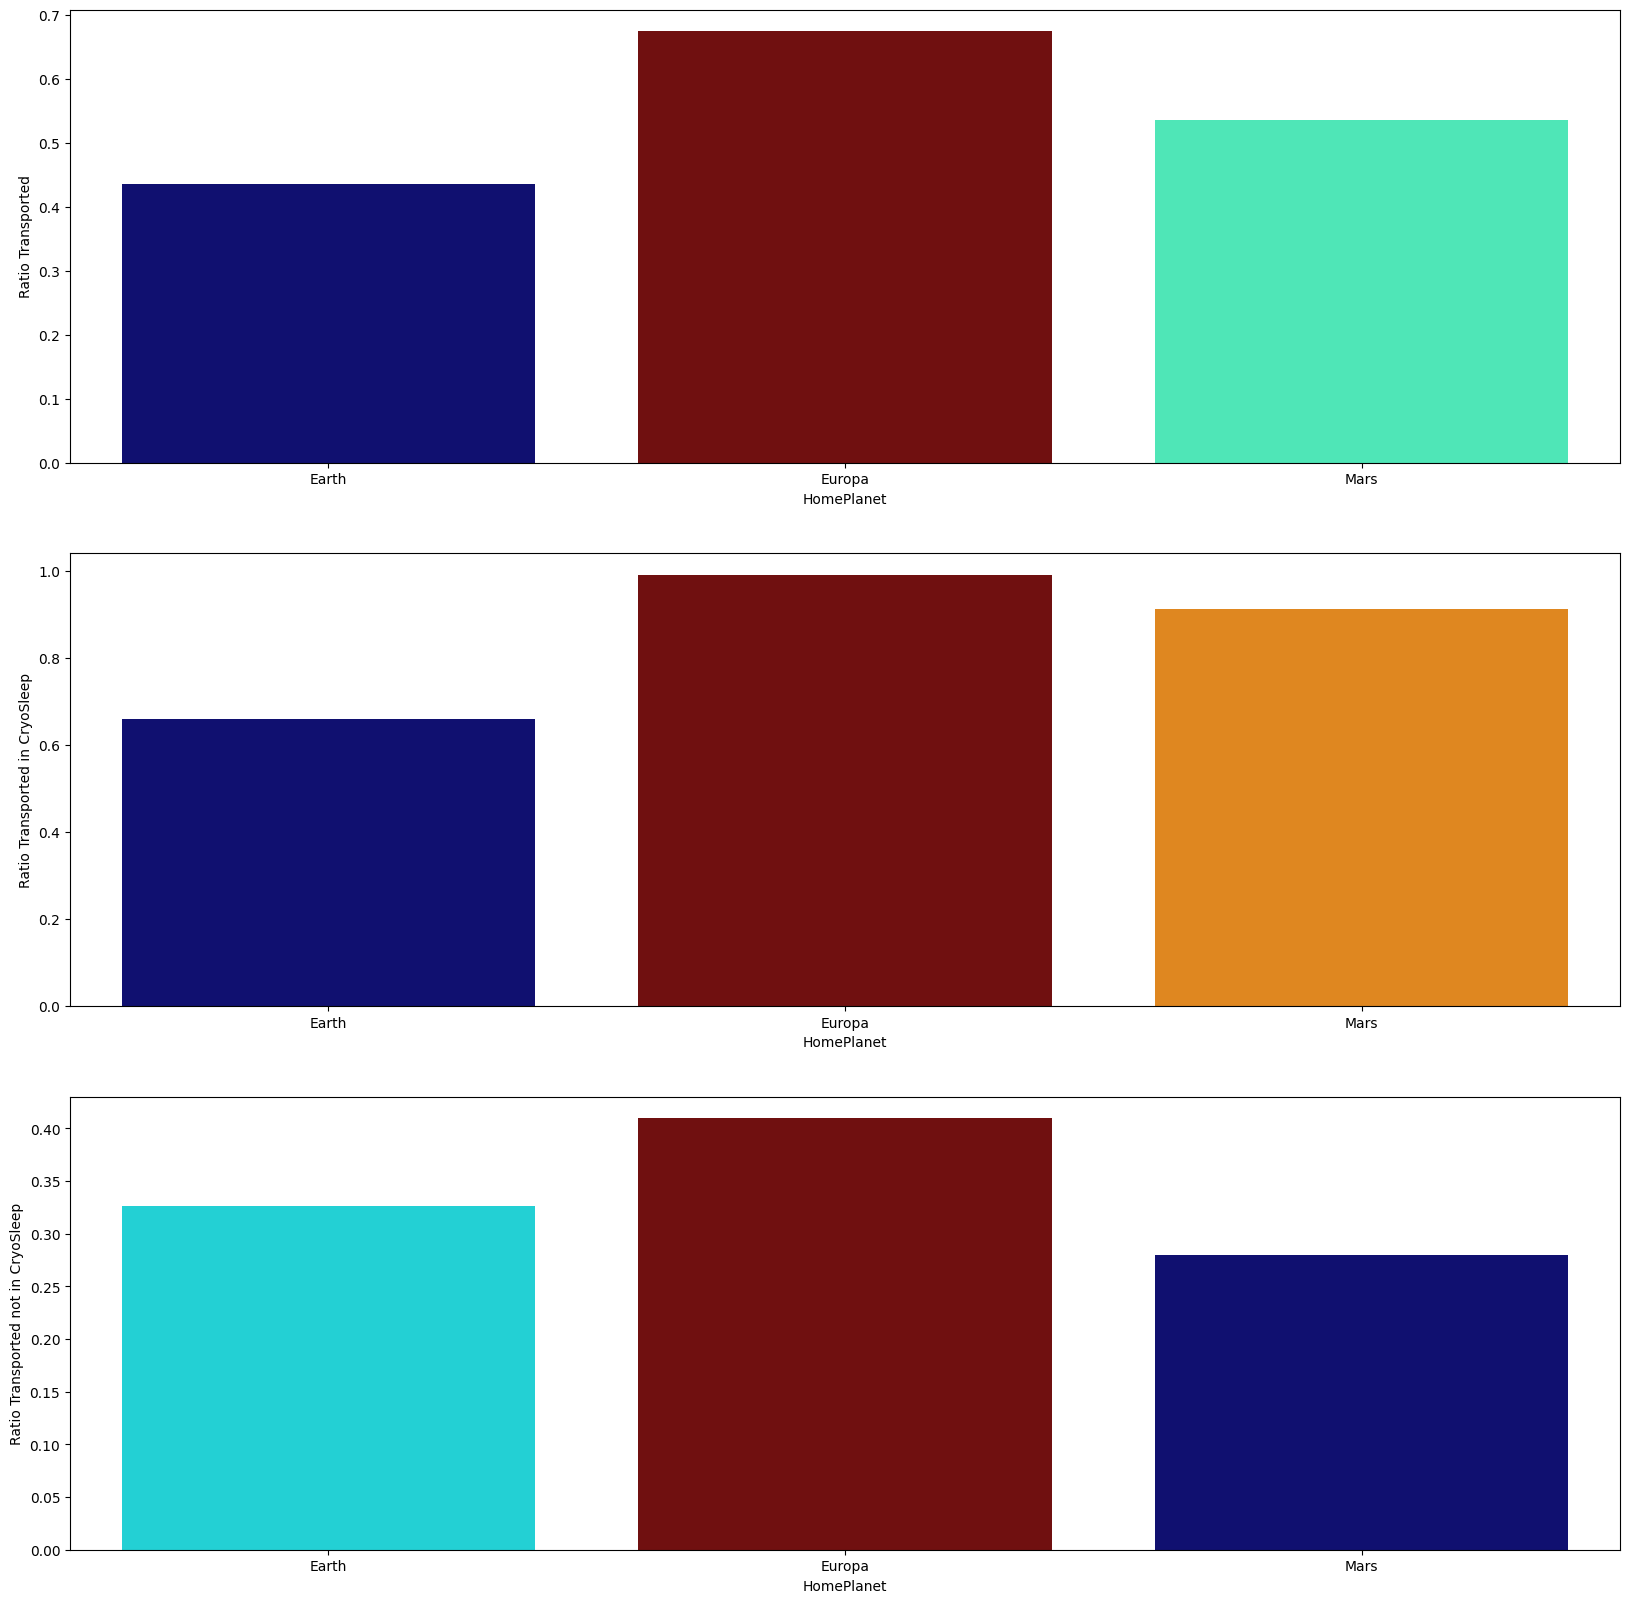

In [43]:
_, _ = plot_ratios_by_Cryo_and_Transported(df0, 'HomePlanet', cat = True)

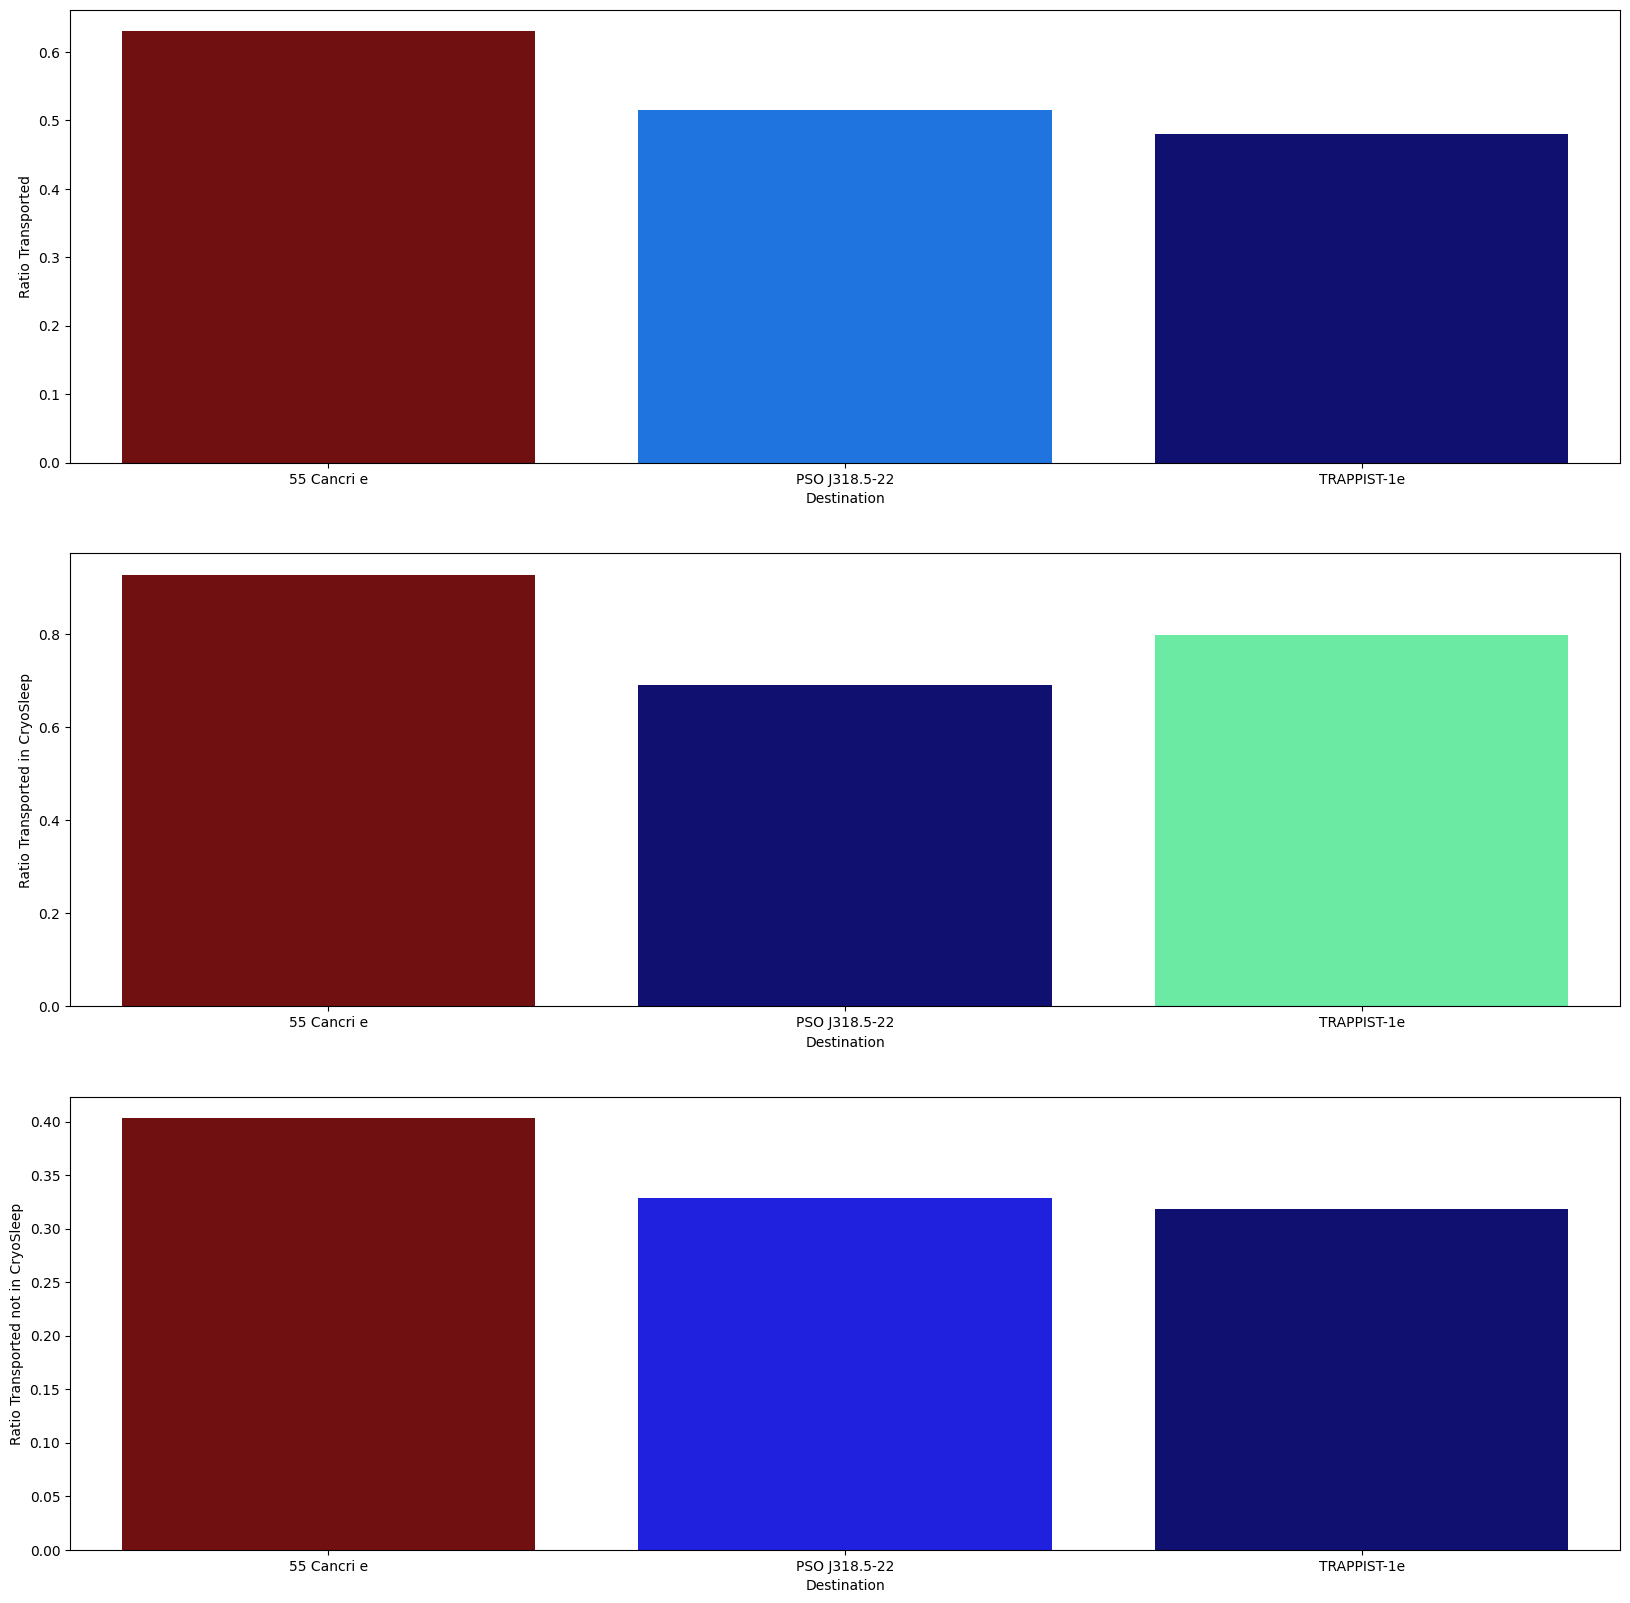

In [44]:
_, _ = plot_ratios_by_Cryo_and_Transported(df0, 'Destination', cat = True)

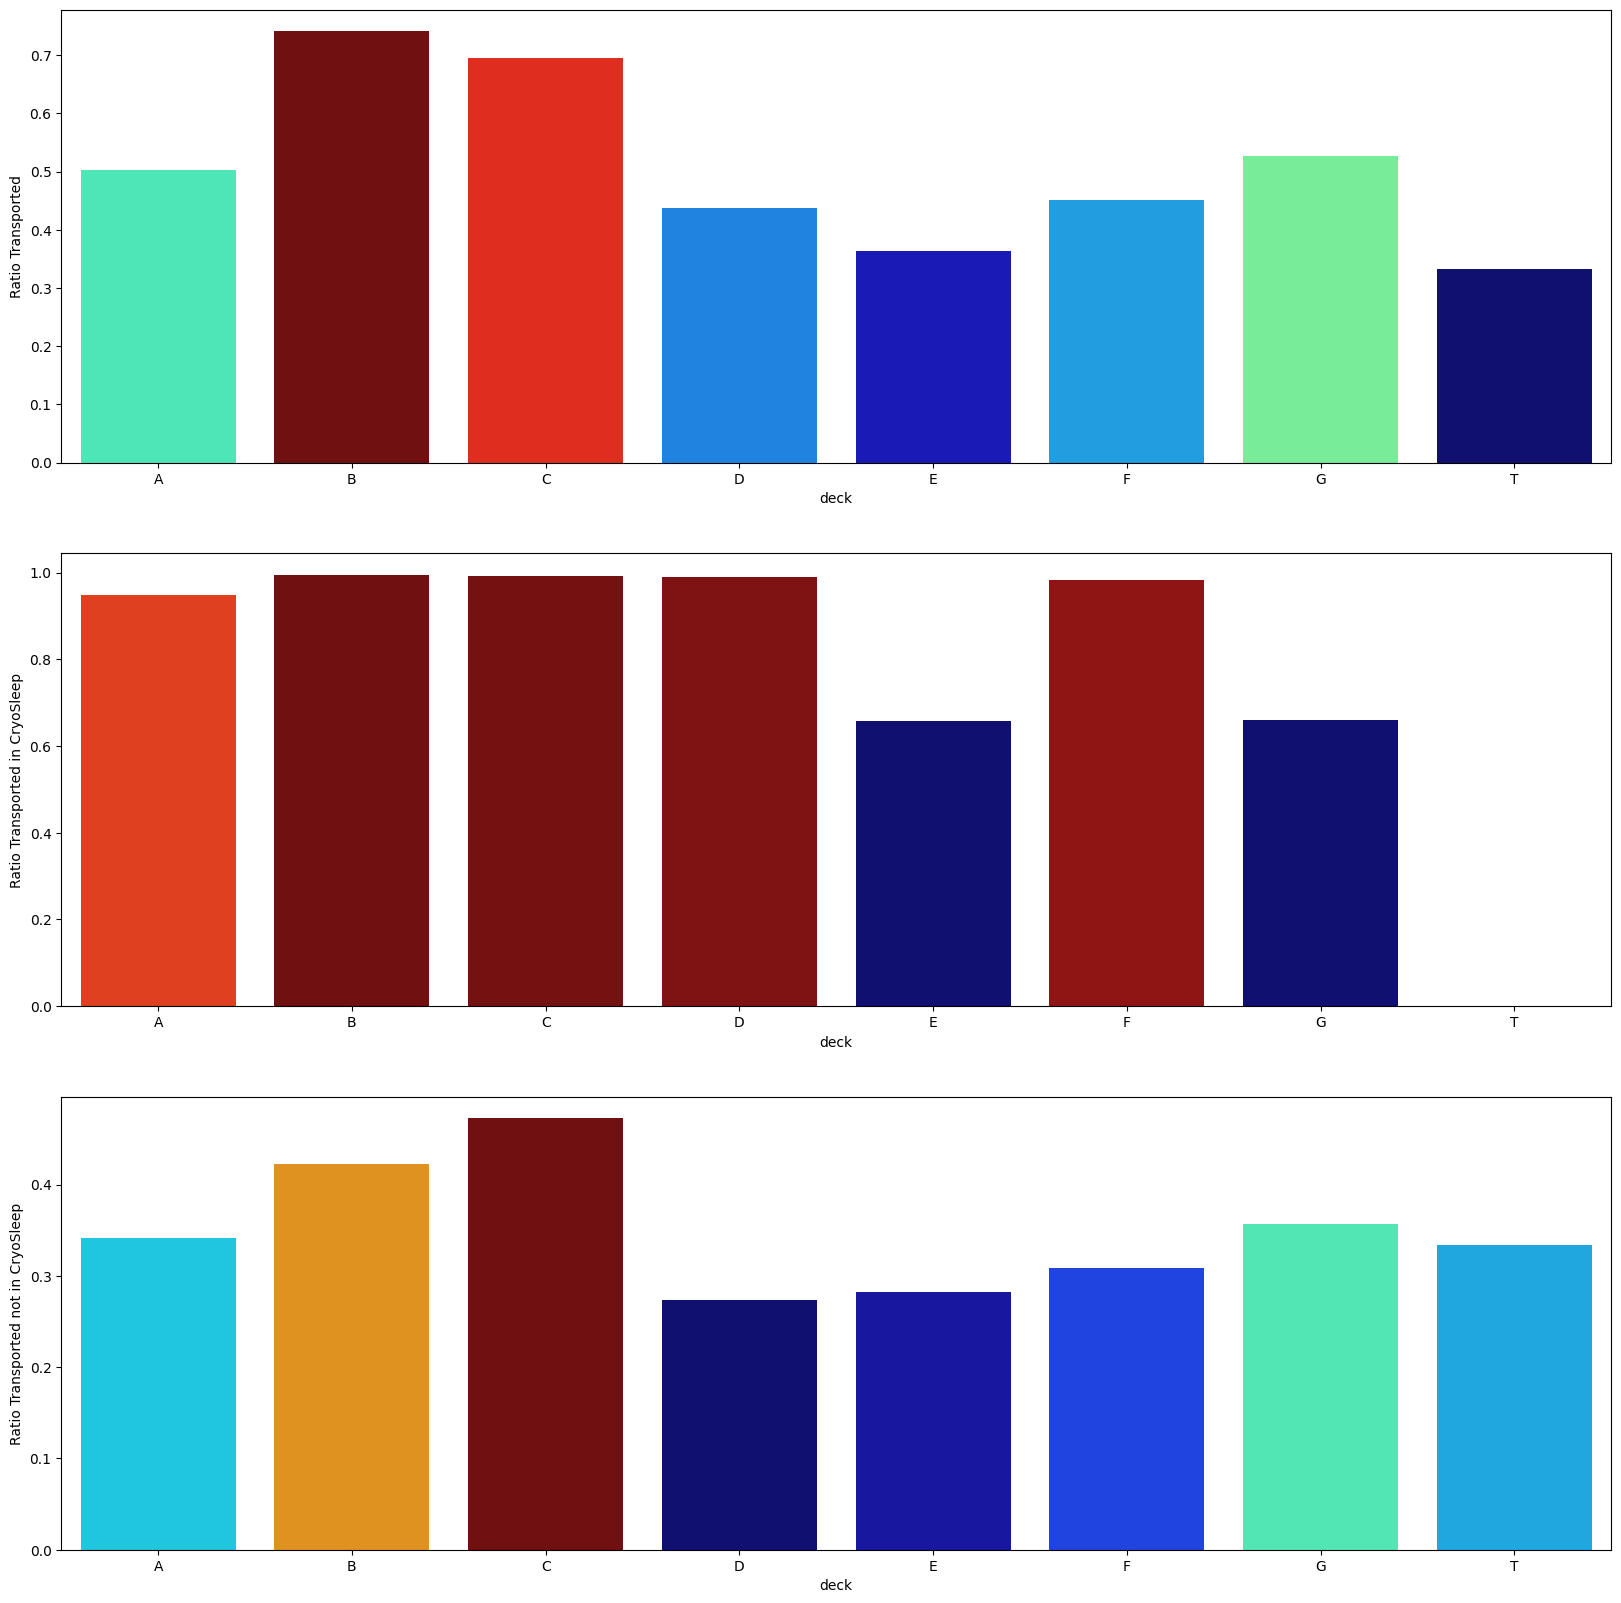

In [45]:
_, _ = plot_ratios_by_Cryo_and_Transported(df0, 'deck', cat = True)

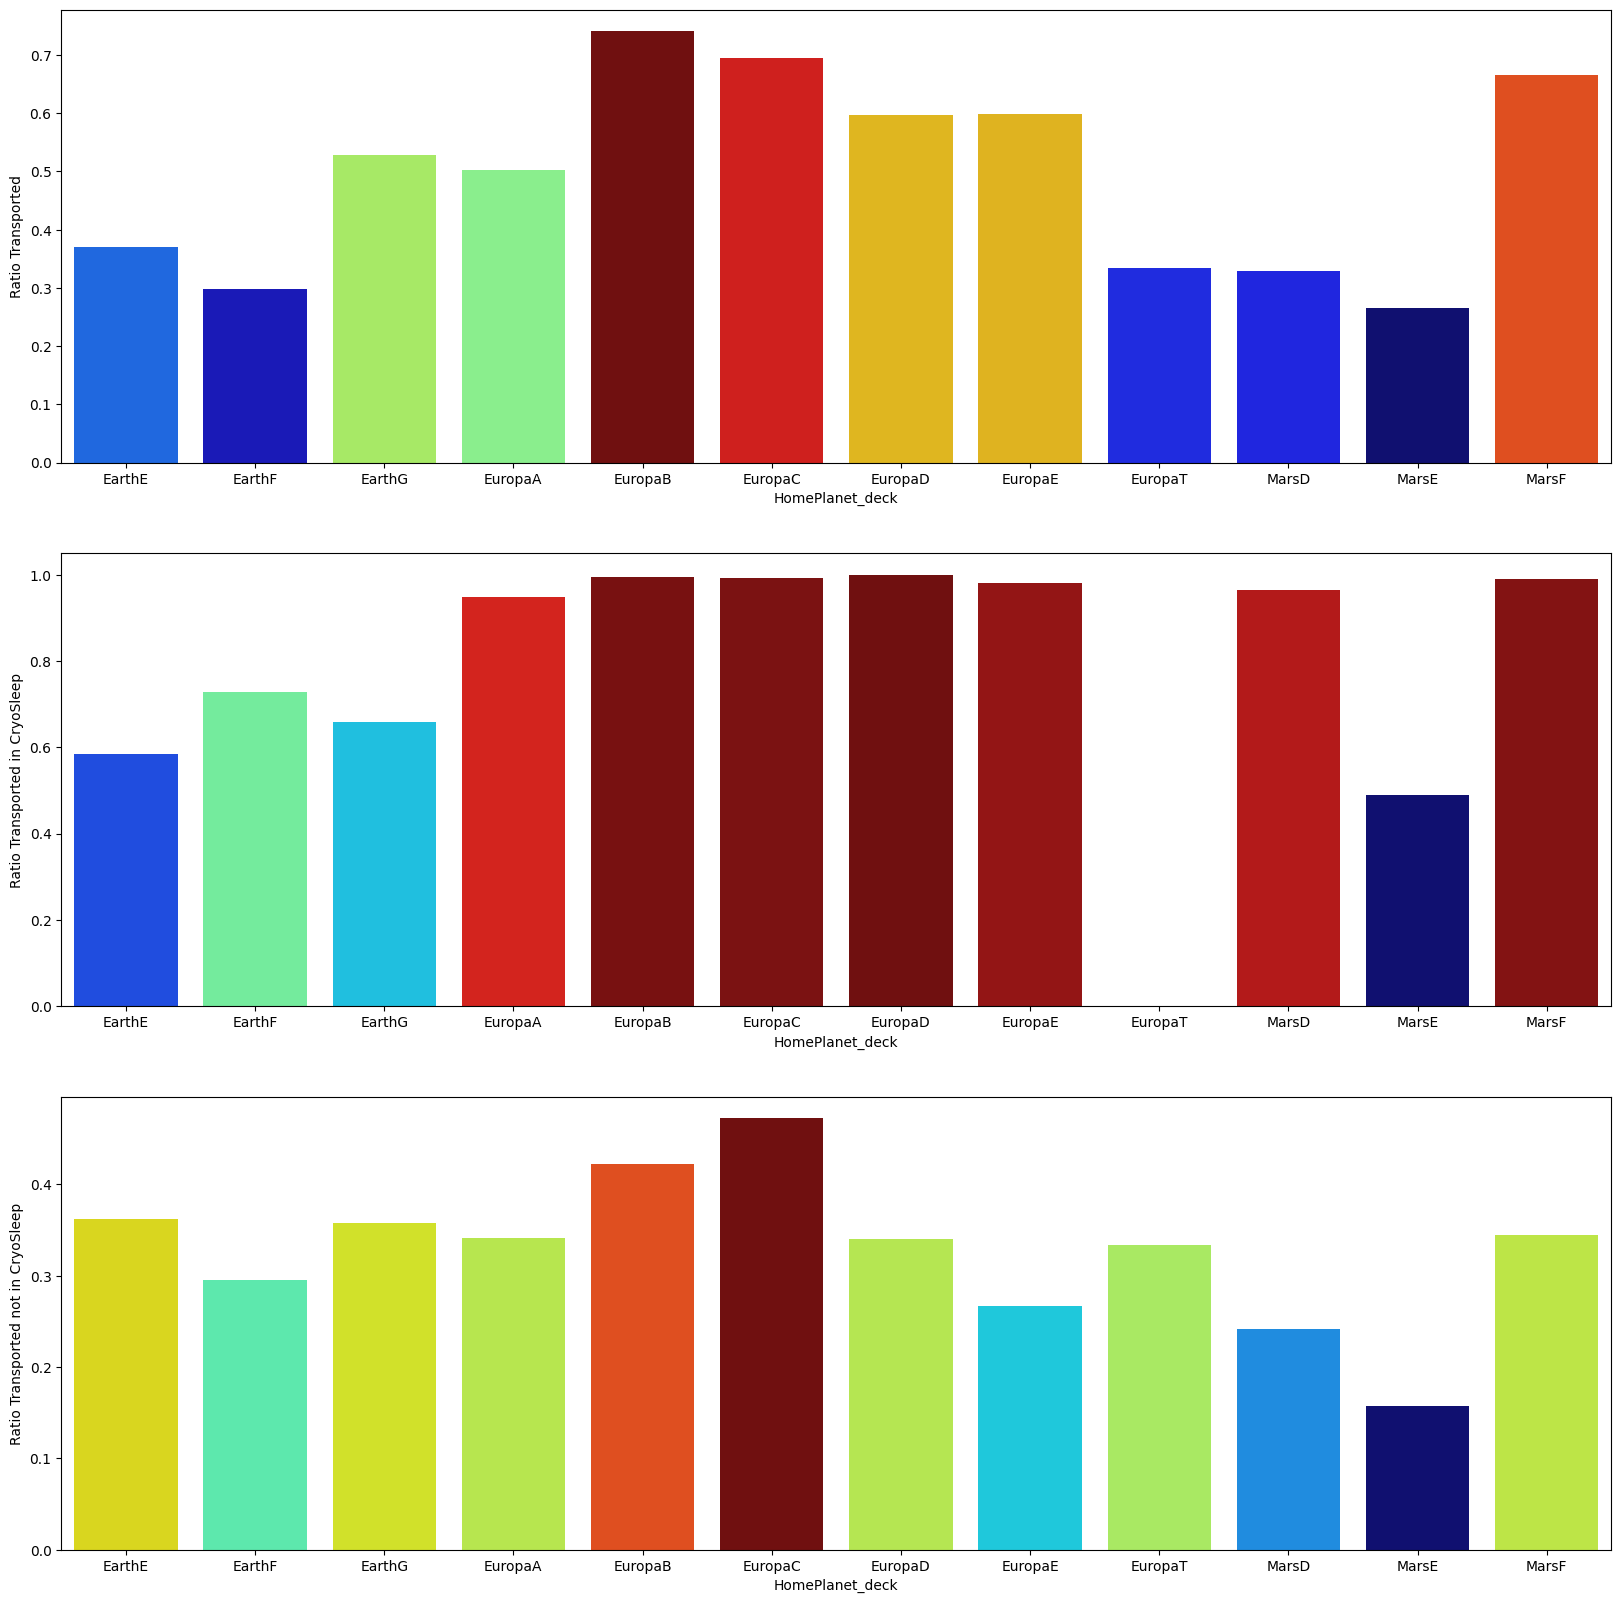

In [46]:
_, _ = plot_ratios_by_Cryo_and_Transported(df0, 'HomePlanet_deck', cat = True)

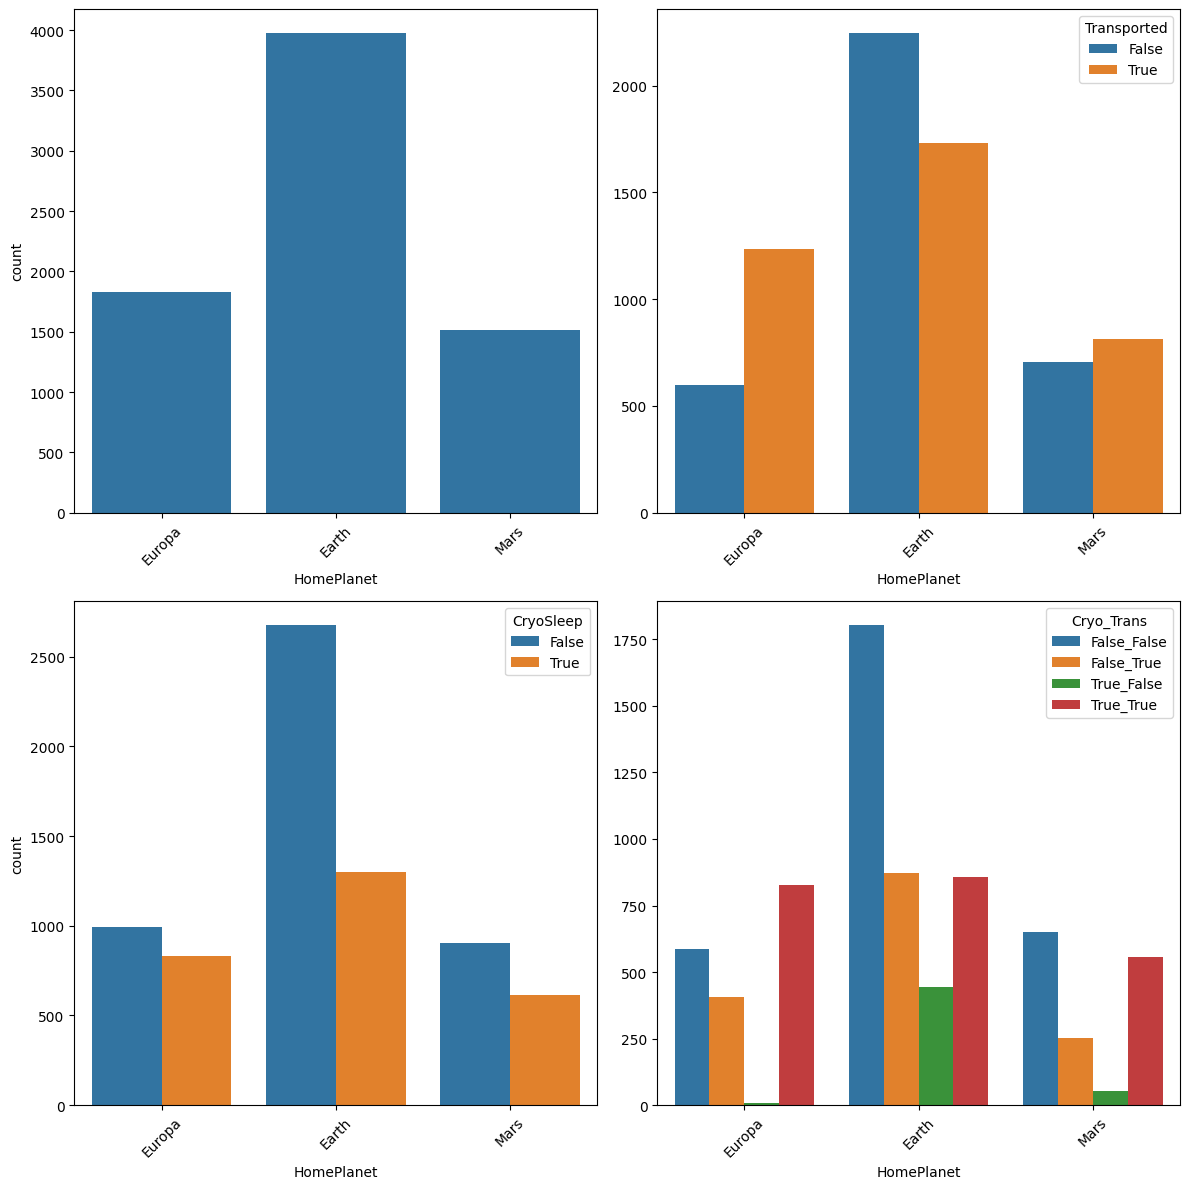

In [47]:
plot_CryoTrans_Counts(df0, 'HomePlanet', df0.HomePlanet.unique().tolist())

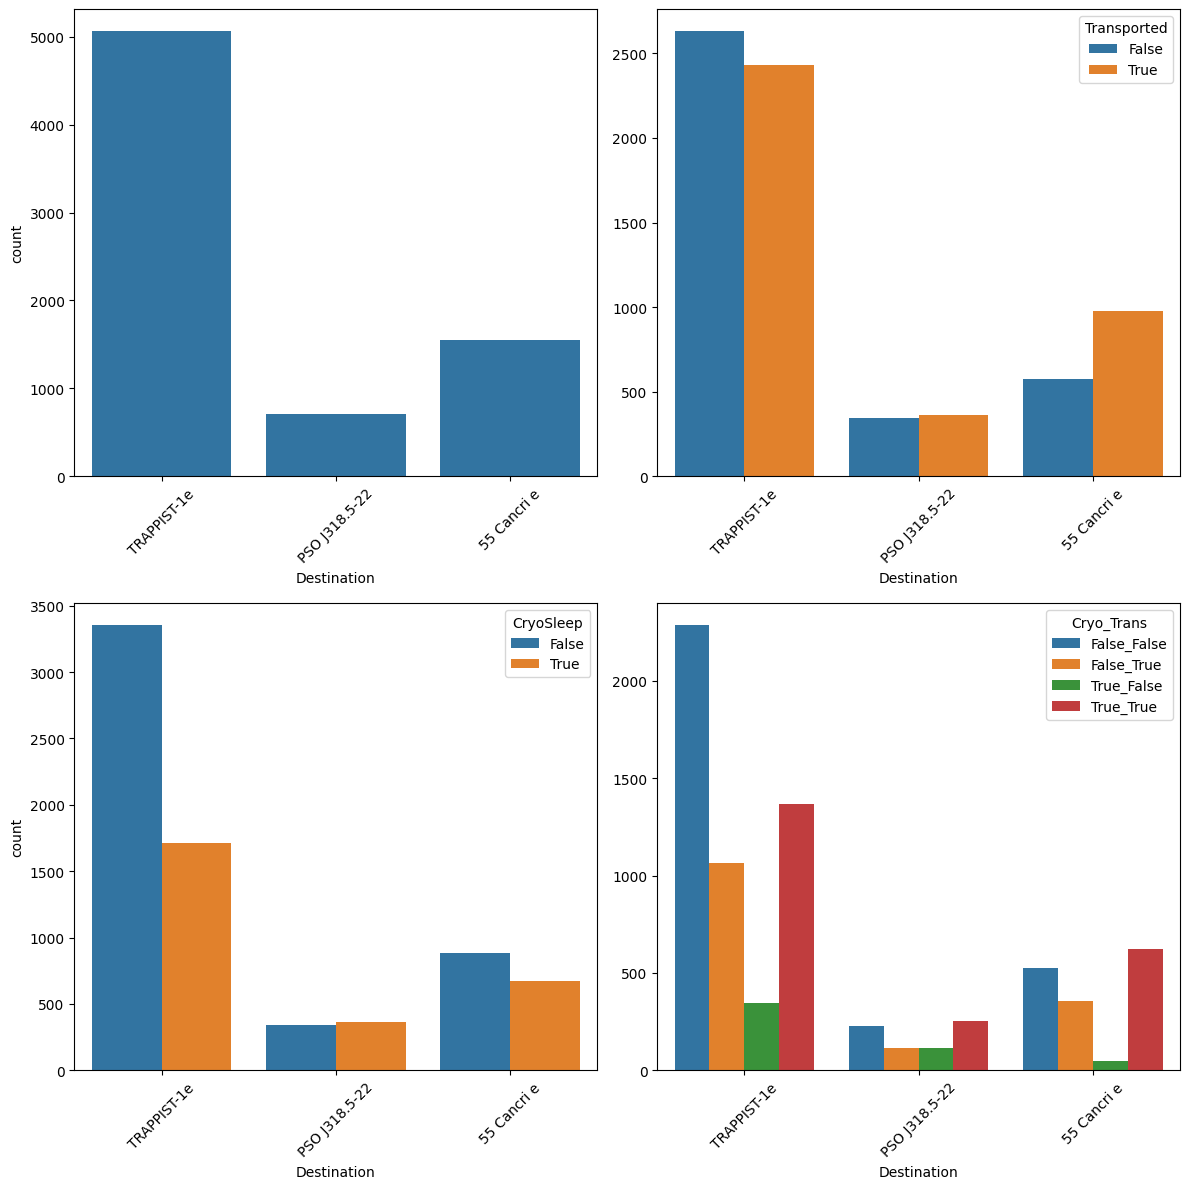

In [48]:
plot_CryoTrans_Counts(df0, 'Destination', df0.Destination.unique().tolist())

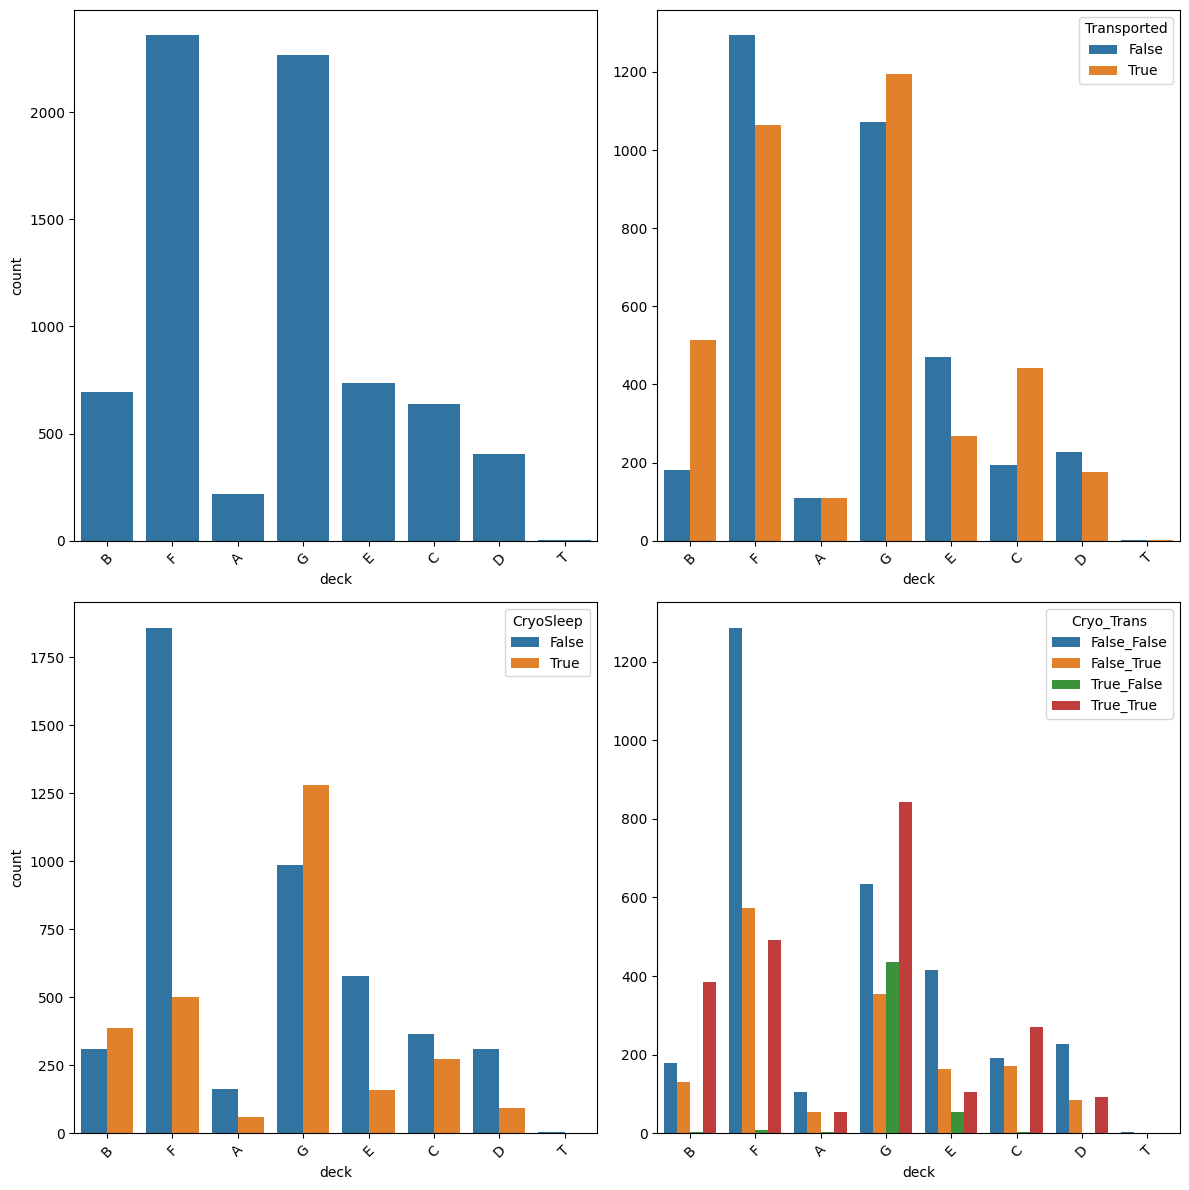

In [49]:
plot_CryoTrans_Counts(df0, 'deck', df0.deck.unique().tolist())

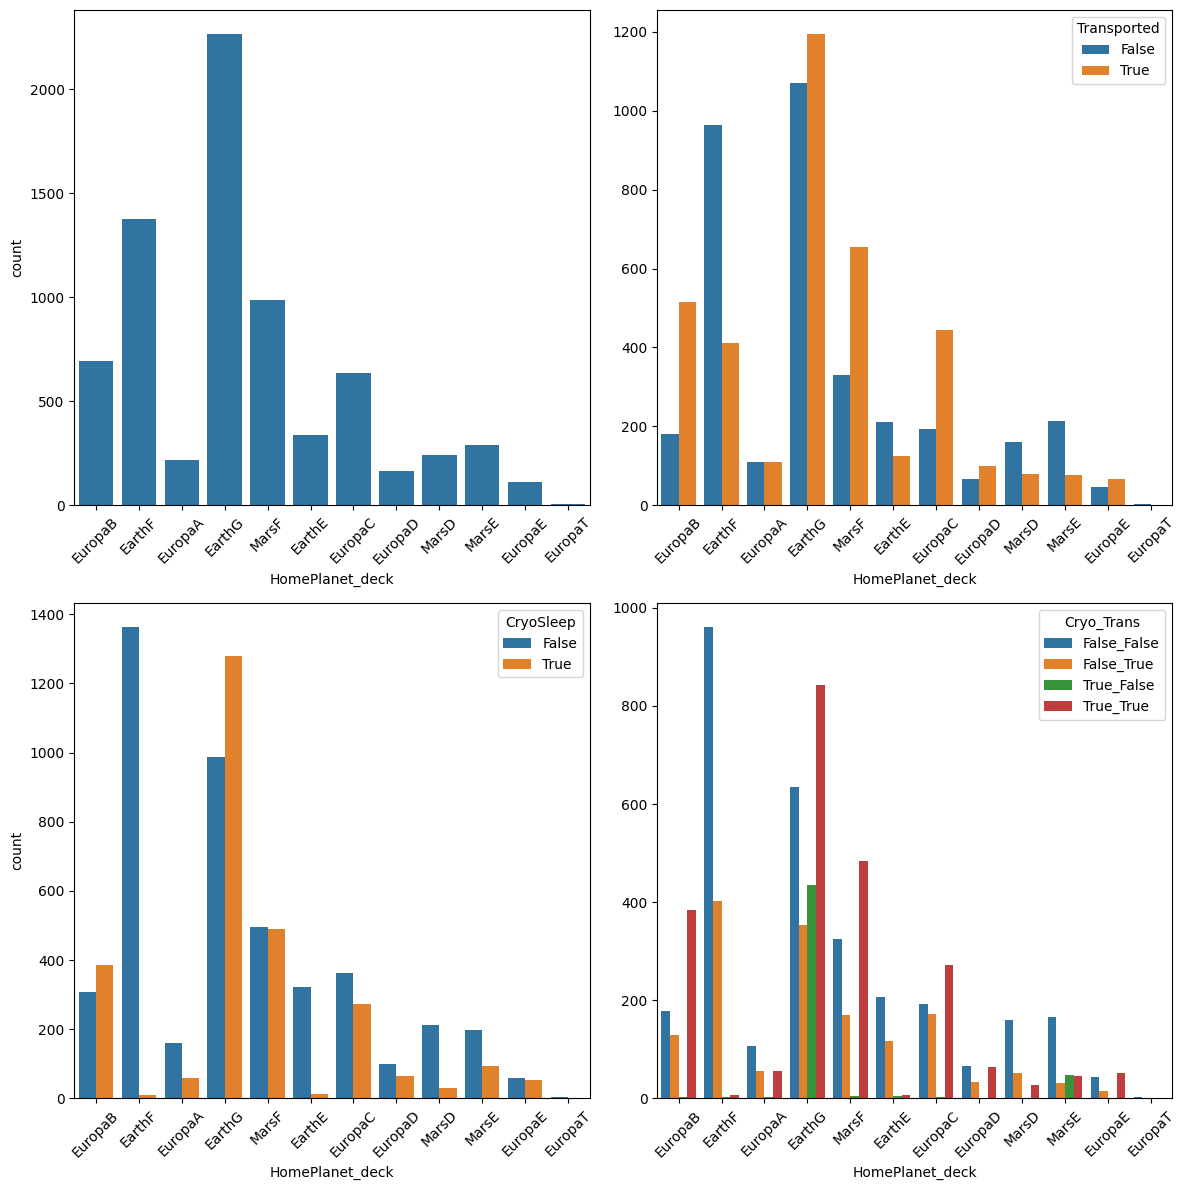

In [50]:
plot_CryoTrans_Counts(df0, 'HomePlanet_deck', df0.HomePlanet_deck.unique().tolist())

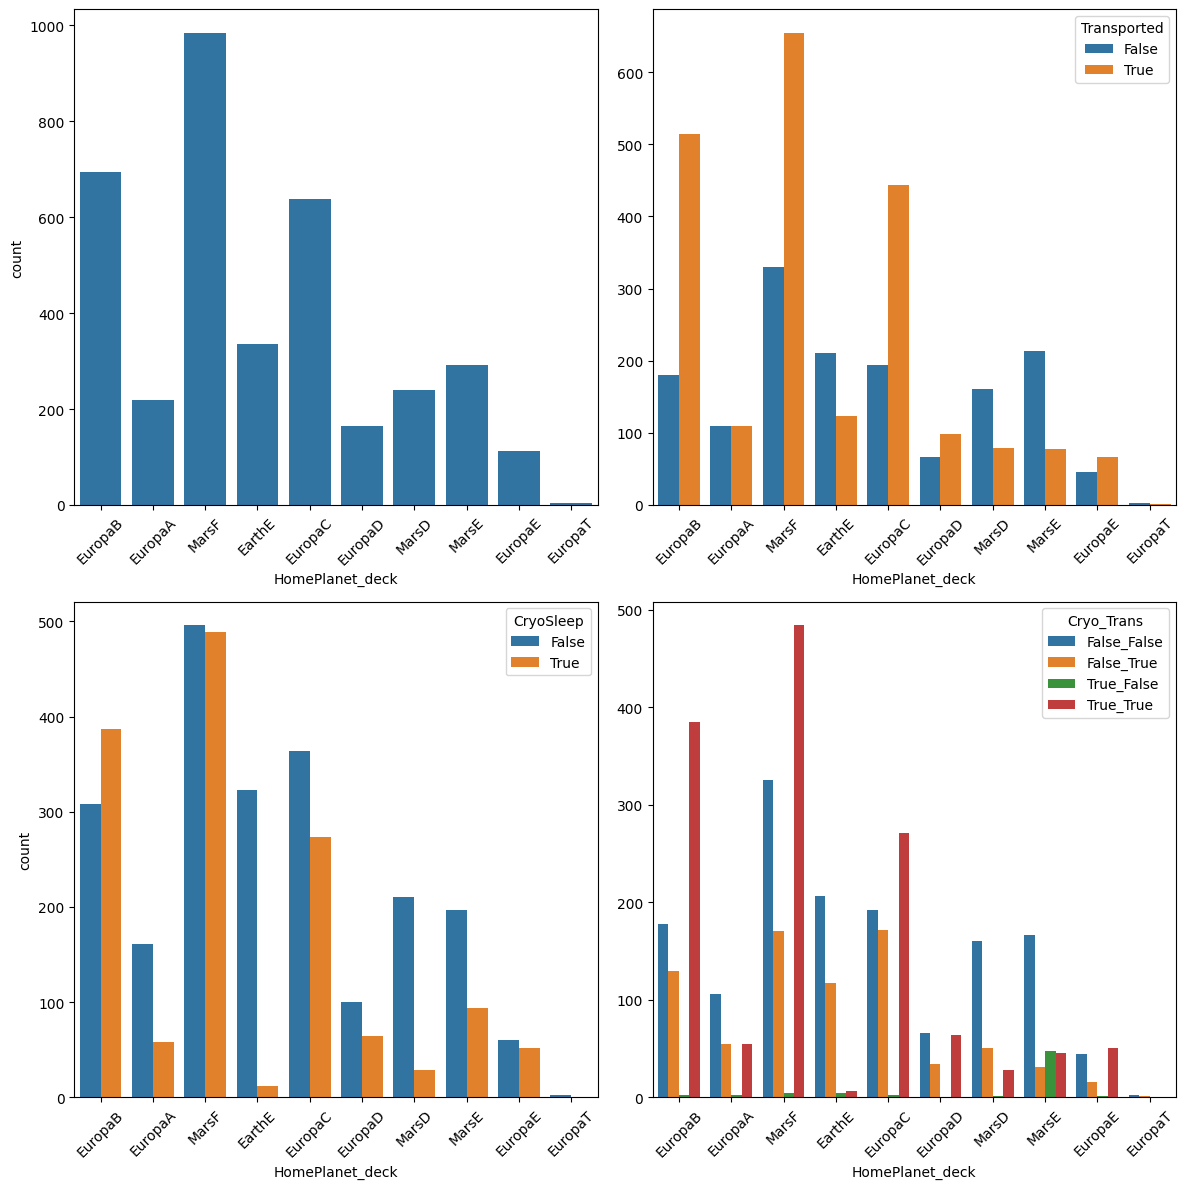

In [51]:
df0_temp = df0[(df0.HomePlanet_deck != 'EarthG') & (df0.HomePlanet_deck != 'EarthF')]
plot_CryoTrans_Counts(df0_temp, 'HomePlanet_deck', df0_temp.HomePlanet_deck.unique().tolist())

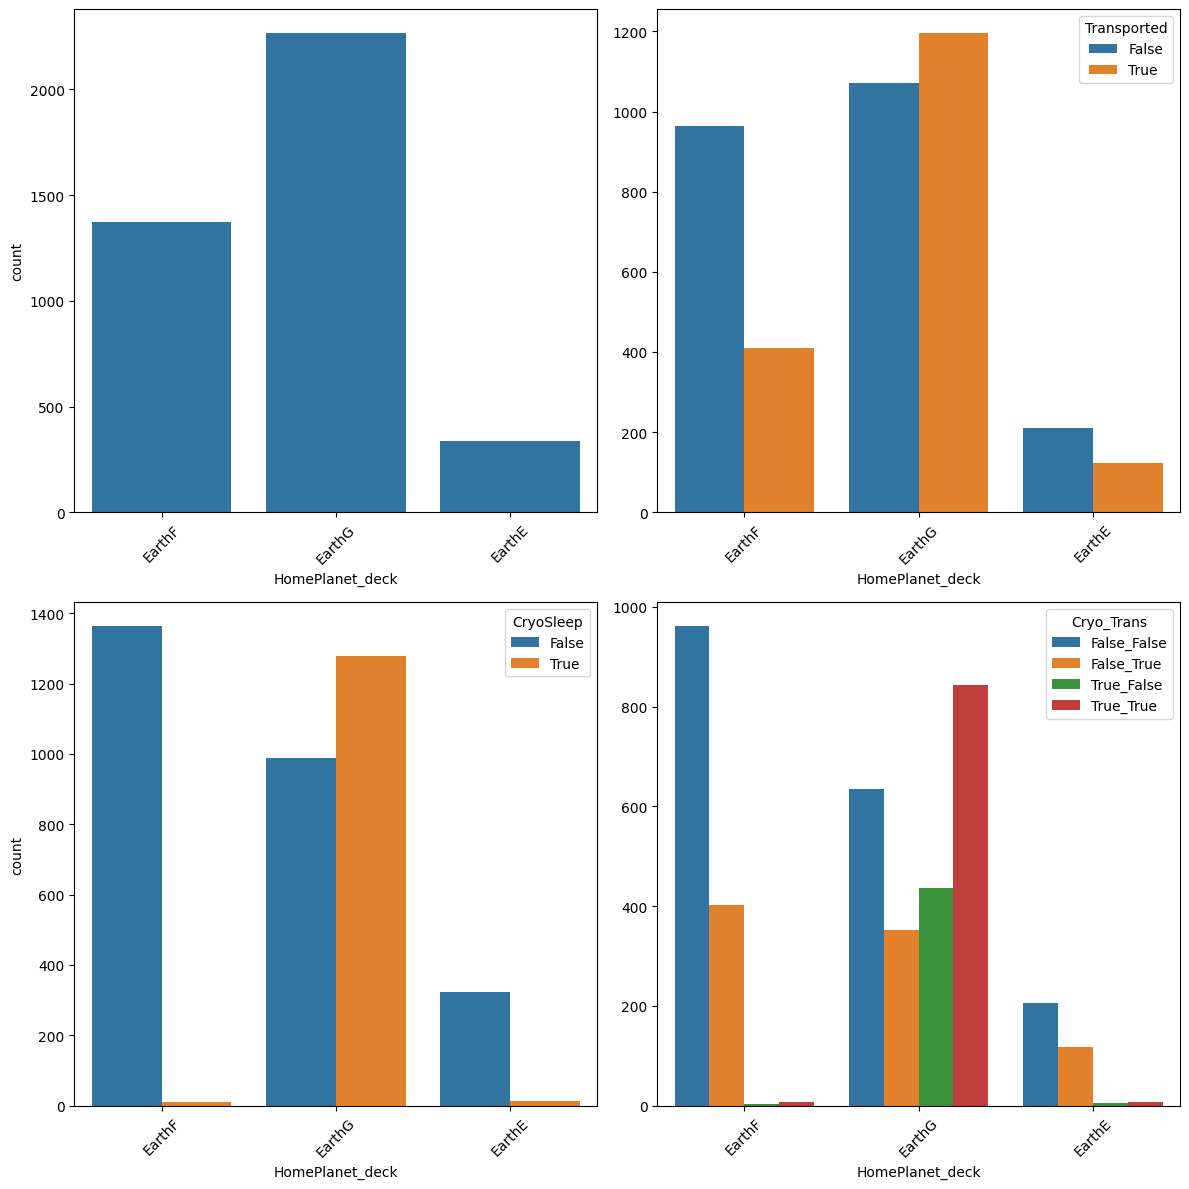

In [52]:
df0_temp = df0[df0.HomePlanet == 'Earth']
plot_CryoTrans_Counts(df0_temp, 'HomePlanet_deck', df0_temp.HomePlanet_deck.unique().tolist())

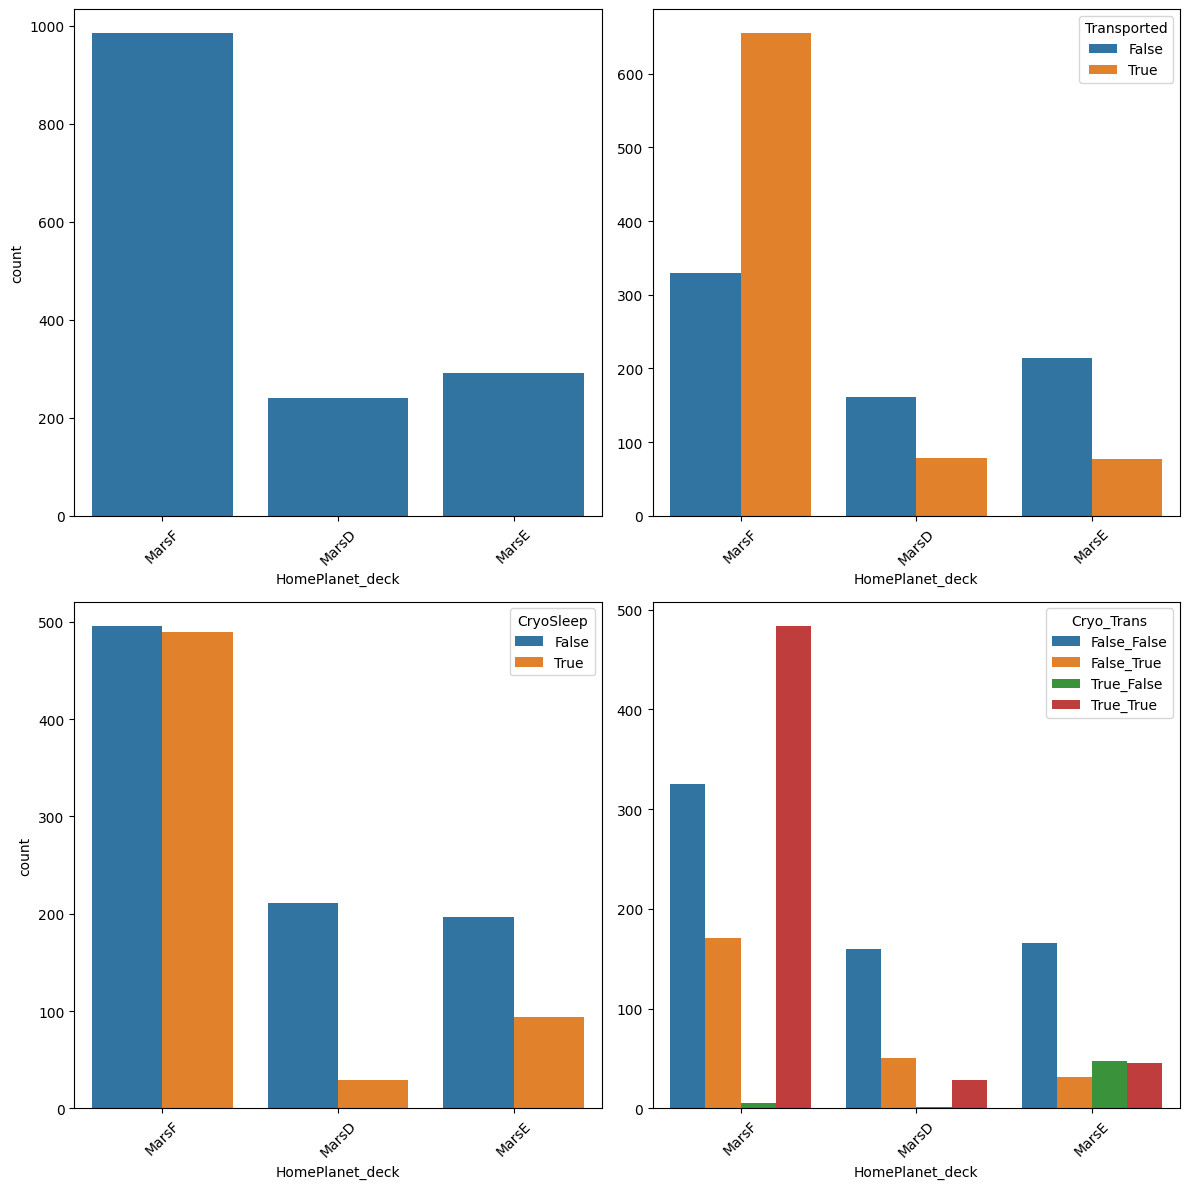

In [53]:
df0_temp = df0[df0.HomePlanet == 'Mars']
plot_CryoTrans_Counts(df0_temp, 'HomePlanet_deck', df0_temp.HomePlanet_deck.unique().tolist())

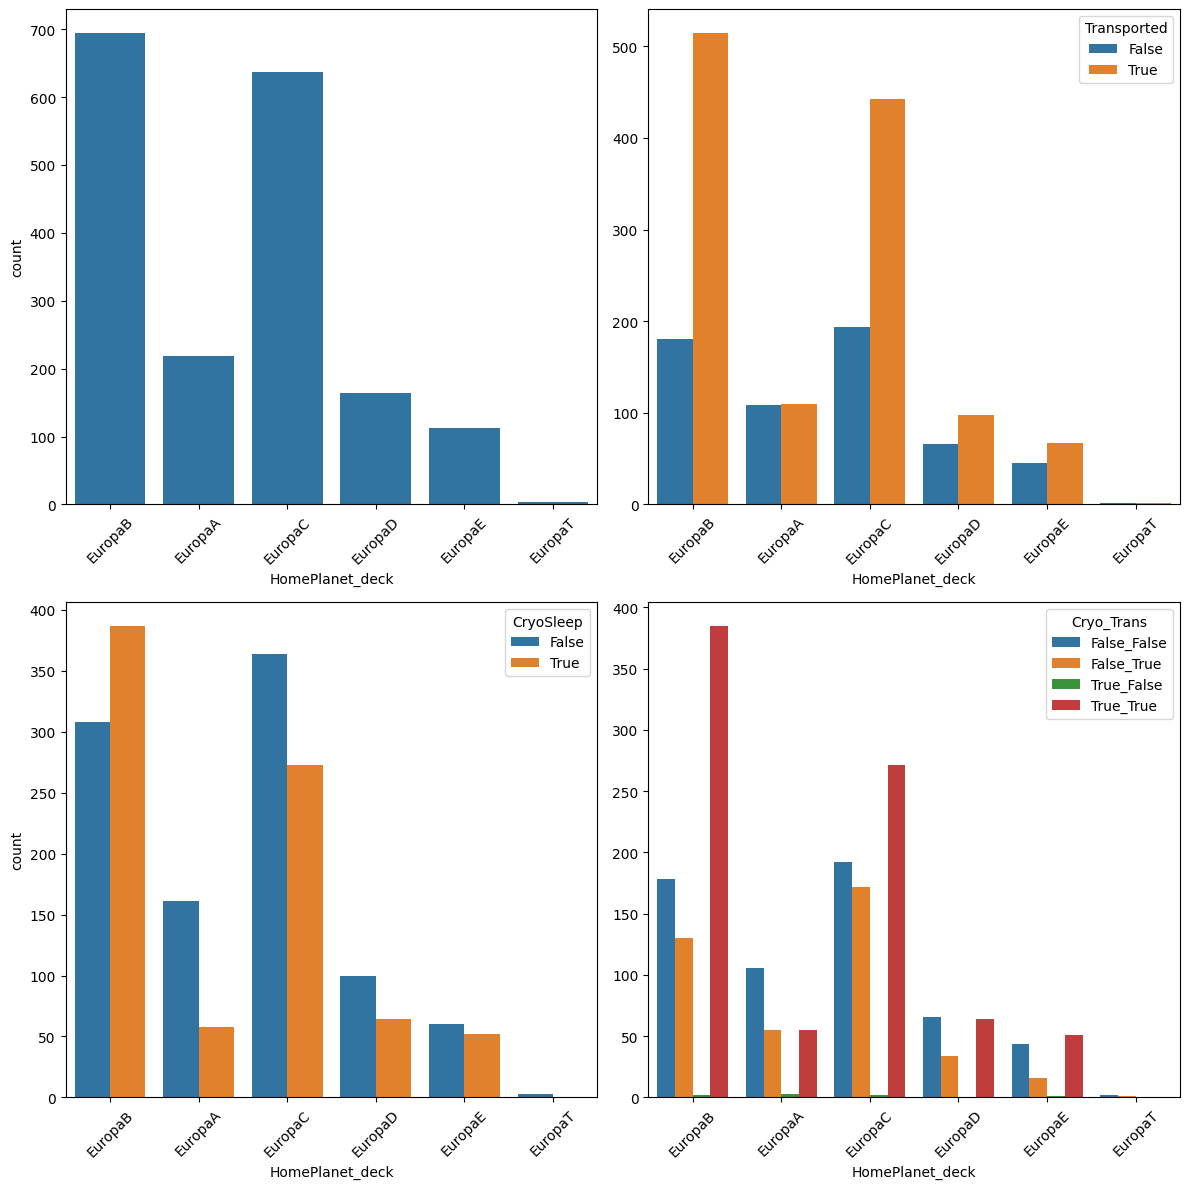

In [54]:
df0_temp = df0[df0.HomePlanet == 'Europa']
plot_CryoTrans_Counts(df0_temp, 'HomePlanet_deck', df0_temp.HomePlanet_deck.unique().tolist())

### Now, let's examine the effect of HomePlanet, Destination, and Deck on few ML algorithms

In [55]:
df0

CryoSleep  Transported HomePlanet    Destination deck  \
PassengerId                                                          
0001_01              0            0     Europa    TRAPPIST-1e    B   
0002_01              0            1      Earth    TRAPPIST-1e    F   
0003_01              0            0     Europa    TRAPPIST-1e    A   
0003_02              0            0     Europa    TRAPPIST-1e    A   
0004_01              0            1      Earth    TRAPPIST-1e    F   
...                ...          ...        ...            ...  ...   
9276_01              0            0     Europa    55 Cancri e    A   
9278_01              1            0      Earth  PSO J318.5-22    G   
9279_01              0            1      Earth    TRAPPIST-1e    G   
9280_01              0            0     Europa    55 Cancri e    E   
9280_02              0            1     Europa    TRAPPIST-1e    E   

            HomePlanet_deck  
PassengerId                  
0001_01             EuropaB  
0002_01              EarthF  
0003_01             EuropaA  
0003_02             EuropaA  
0004_01              EarthF  
...                     ...  
9276_01             EuropaA  
9278_01              EarthG  
9279_01              EarthG  
9280_01             EuropaE  
9280_02             EuropaE  

[7322 rows x 6 columns]

In [56]:
df0_base

Spa  RoomService    VRDeck  FoodCourt  ShoppingMall  \
PassengerId                                                             
0001_01      0.000000     0.000000  0.000000   0.000000      0.000000   
0002_01      6.309918     4.700480  3.806662   2.302585      3.258097   
0003_01      8.812248     3.784190  3.912023   8.182280      0.000000   
0003_02      8.110728     0.000000  5.267858   7.157735      5.918894   
0004_01      6.338594     5.717028  1.098612   4.262680      5.023881   
...               ...          ...       ...        ...           ...   
9276_01      7.404888     0.000000  4.317488   8.827615      0.000000   
9278_01      0.000000     0.000000  0.000000   0.000000      0.000000   
9279_01      0.693147     0.000000  0.000000   0.000000      7.535297   
9280_01      5.869297     0.000000  8.082093   6.956545      0.000000   
9280_02      0.000000     4.844187  2.564949   8.452975      0.000000   

             Under_13  
PassengerId            
0001_01             0  
0002_01             0  
0003_01             0  
0003_02             0  
0004_01             0  
...               ...  
9276_01             0  
9278_01             0  
9279_01             0  
9280_01             0  
9280_02             0  

[7322 rows x 6 columns]

In [57]:
df1 = pd.concat([df0[['CryoSleep', 'Transported']], df0_base], axis = 1)
for feature in ['HomePlanet', 'Destination', 'deck', 'HomePlanet_deck']:
    prefix = feature if feature != 'HomePlanet_deck' else 'HD'
    one_hot_encoded = pd.get_dummies(df0[feature], prefix = prefix).astype(int)
    df1 = pd.concat([df1, one_hot_encoded], axis = 1)

HomePlanet_Features = [col for col in df1.columns if col.startswith('HomePlanet_')]
Destination_Features = [col for col in df1.columns if col.startswith('Destination_')]
deck_Features = [col for col in df1.columns if col.startswith('deck_')]
HomePlanet_deck_Features = [col for col in df1.columns if col.startswith('HD_')]

In [58]:
basic_list = ['CryoSleep']
features_list = HomePlanet_Features
Compare_Ordered_Feature_Lists(df1, 'Transported', basic_list, features_list, Kfold = 10)

List0:  ['CryoSleep']
List1:  ['CryoSleep', 'HomePlanet_Earth']
List2:  ['CryoSleep', 'HomePlanet_Earth', 'HomePlanet_Europa']
List3:  ['CryoSleep', 'HomePlanet_Earth', 'HomePlanet_Europa', 'HomePlanet_Mars']


In [59]:
basic_list = ['CryoSleep'] + Features0
features_list = HomePlanet_Features
Compare_Ordered_Feature_Lists(df1, 'Transported', basic_list, features_list, Kfold = 10)

List0:  ['CryoSleep', 'Spa', 'RoomService', 'VRDeck', 'FoodCourt', 'ShoppingMall', 'Under_13']
List1:  ['CryoSleep', 'Spa', 'RoomService', 'VRDeck', 'FoodCourt', 'ShoppingMall', 'Under_13', 'HomePlanet_Earth']
List2:  ['CryoSleep', 'Spa', 'RoomService', 'VRDeck', 'FoodCourt', 'ShoppingMall', 'Under_13', 'HomePlanet_Earth', 'HomePlanet_Europa']
List3:  ['CryoSleep', 'Spa', 'RoomService', 'VRDeck', 'FoodCourt', 'ShoppingMall', 'Under_13', 'HomePlanet_Earth', 'HomePlanet_Europa', 'HomePlanet_Mars']


In [60]:
basic_list = ['CryoSleep']
features_list = Destination_Features
Compare_Ordered_Feature_Lists(df1, 'Transported', basic_list, features_list, Kfold = 10)

List0:  ['CryoSleep']
List1:  ['CryoSleep', 'Destination_55 Cancri e']
List2:  ['CryoSleep', 'Destination_55 Cancri e', 'Destination_PSO J318.5-22']
List3:  ['CryoSleep', 'Destination_55 Cancri e', 'Destination_PSO J318.5-22', 'Destination_TRAPPIST-1e']


In [61]:
basic_list = ['CryoSleep'] + Features0
features_list = Destination_Features
Compare_Ordered_Feature_Lists(df1, 'Transported', basic_list, features_list, Kfold = 10)

List0:  ['CryoSleep', 'Spa', 'RoomService', 'VRDeck', 'FoodCourt', 'ShoppingMall', 'Under_13']
List1:  ['CryoSleep', 'Spa', 'RoomService', 'VRDeck', 'FoodCourt', 'ShoppingMall', 'Under_13', 'Destination_55 Cancri e']
List2:  ['CryoSleep', 'Spa', 'RoomService', 'VRDeck', 'FoodCourt', 'ShoppingMall', 'Under_13', 'Destination_55 Cancri e', 'Destination_PSO J318.5-22']
List3:  ['CryoSleep', 'Spa', 'RoomService', 'VRDeck', 'FoodCourt', 'ShoppingMall', 'Under_13', 'Destination_55 Cancri e', 'Destination_PSO J318.5-22', 'Destination_TRAPPIST-1e']


In [62]:
basic_list = ['CryoSleep']
features_list = deck_Features
Compare_Ordered_Feature_Lists(df1, 'Transported', basic_list, features_list, Kfold = 10)

List0:  ['CryoSleep']
List1:  ['CryoSleep', 'deck_A']
List2:  ['CryoSleep', 'deck_A', 'deck_B']
List3:  ['CryoSleep', 'deck_A', 'deck_B', 'deck_C']
List4:  ['CryoSleep', 'deck_A', 'deck_B', 'deck_C', 'deck_D']
List5:  ['CryoSleep', 'deck_A', 'deck_B', 'deck_C', 'deck_D', 'deck_E']
List6:  ['CryoSleep', 'deck_A', 'deck_B', 'deck_C', 'deck_D', 'deck_E', 'deck_F']
List7:  ['CryoSleep', 'deck_A', 'deck_B', 'deck_C', 'deck_D', 'deck_E', 'deck_F', 'deck_G']
List8:  ['CryoSleep', 'deck_A', 'deck_B', 'deck_C', 'deck_D', 'deck_E', 'deck_F', 'deck_G', 'deck_T']


In [63]:
basic_list = ['CryoSleep'] + Features0
features_list = deck_Features
Compare_Ordered_Feature_Lists(df1, 'Transported', basic_list, features_list, Kfold = 10)

List0:  ['CryoSleep', 'Spa', 'RoomService', 'VRDeck', 'FoodCourt', 'ShoppingMall', 'Under_13']
List1:  ['CryoSleep', 'Spa', 'RoomService', 'VRDeck', 'FoodCourt', 'ShoppingMall', 'Under_13', 'deck_A']
List2:  ['CryoSleep', 'Spa', 'RoomService', 'VRDeck', 'FoodCourt', 'ShoppingMall', 'Under_13', 'deck_A', 'deck_B']
List3:  ['CryoSleep', 'Spa', 'RoomService', 'VRDeck', 'FoodCourt', 'ShoppingMall', 'Under_13', 'deck_A', 'deck_B', 'deck_C']
List4:  ['CryoSleep', 'Spa', 'RoomService', 'VRDeck', 'FoodCourt', 'ShoppingMall', 'Under_13', 'deck_A', 'deck_B', 'deck_C', 'deck_D']
List5:  ['CryoSleep', 'Spa', 'RoomService', 'VRDeck', 'FoodCourt', 'ShoppingMall', 'Under_13', 'deck_A', 'deck_B', 'deck_C', 'deck_D', 'deck_E']
List6:  ['CryoSleep', 'Spa', 'RoomService', 'VRDeck', 'FoodCourt', 'ShoppingMall', 'Under_13', 'deck_A', 'deck_B', 'deck_C', 'deck_D', 'deck_E', 'deck_F']
List7:  ['CryoSleep', 'Spa', 'RoomService', 'VRDeck', 'FoodCourt', 'ShoppingMall', 'Under_13', 'deck_A', 'deck_B', 'deck_C', 

In [64]:
basic_list = ['CryoSleep']
features_list = HomePlanet_deck_Features
Compare_Ordered_Feature_Lists(df1, 'Transported', basic_list, features_list, Kfold = 10)

List0:  ['CryoSleep']
List1:  ['CryoSleep', 'HD_EarthE']
List2:  ['CryoSleep', 'HD_EarthE', 'HD_EarthF']
List3:  ['CryoSleep', 'HD_EarthE', 'HD_EarthF', 'HD_EarthG']
List4:  ['CryoSleep', 'HD_EarthE', 'HD_EarthF', 'HD_EarthG', 'HD_EuropaA']
List5:  ['CryoSleep', 'HD_EarthE', 'HD_EarthF', 'HD_EarthG', 'HD_EuropaA', 'HD_EuropaB']
List6:  ['CryoSleep', 'HD_EarthE', 'HD_EarthF', 'HD_EarthG', 'HD_EuropaA', 'HD_EuropaB', 'HD_EuropaC']
List7:  ['CryoSleep', 'HD_EarthE', 'HD_EarthF', 'HD_EarthG', 'HD_EuropaA', 'HD_EuropaB', 'HD_EuropaC', 'HD_EuropaD']
List8:  ['CryoSleep', 'HD_EarthE', 'HD_EarthF', 'HD_EarthG', 'HD_EuropaA', 'HD_EuropaB', 'HD_EuropaC', 'HD_EuropaD', 'HD_EuropaE']
List9:  ['CryoSleep', 'HD_EarthE', 'HD_EarthF', 'HD_EarthG', 'HD_EuropaA', 'HD_EuropaB', 'HD_EuropaC', 'HD_EuropaD', 'HD_EuropaE', 'HD_EuropaT']
List10:  ['CryoSleep', 'HD_EarthE', 'HD_EarthF', 'HD_EarthG', 'HD_EuropaA', 'HD_EuropaB', 'HD_EuropaC', 'HD_EuropaD', 'HD_EuropaE', 'HD_EuropaT', 'HD_MarsD']
List11:  ['CryoS

In [65]:
basic_list = ['CryoSleep'] + Features0
features_list = HomePlanet_deck_Features
Compare_Ordered_Feature_Lists(df1, 'Transported', basic_list, features_list, Kfold = 10)

List0:  ['CryoSleep', 'Spa', 'RoomService', 'VRDeck', 'FoodCourt', 'ShoppingMall', 'Under_13']
List1:  ['CryoSleep', 'Spa', 'RoomService', 'VRDeck', 'FoodCourt', 'ShoppingMall', 'Under_13', 'HD_EarthE']
List2:  ['CryoSleep', 'Spa', 'RoomService', 'VRDeck', 'FoodCourt', 'ShoppingMall', 'Under_13', 'HD_EarthE', 'HD_EarthF']
List3:  ['CryoSleep', 'Spa', 'RoomService', 'VRDeck', 'FoodCourt', 'ShoppingMall', 'Under_13', 'HD_EarthE', 'HD_EarthF', 'HD_EarthG']
List4:  ['CryoSleep', 'Spa', 'RoomService', 'VRDeck', 'FoodCourt', 'ShoppingMall', 'Under_13', 'HD_EarthE', 'HD_EarthF', 'HD_EarthG', 'HD_EuropaA']
List5:  ['CryoSleep', 'Spa', 'RoomService', 'VRDeck', 'FoodCourt', 'ShoppingMall', 'Under_13', 'HD_EarthE', 'HD_EarthF', 'HD_EarthG', 'HD_EuropaA', 'HD_EuropaB']
List6:  ['CryoSleep', 'Spa', 'RoomService', 'VRDeck', 'FoodCourt', 'ShoppingMall', 'Under_13', 'HD_EarthE', 'HD_EarthF', 'HD_EarthG', 'HD_EuropaA', 'HD_EuropaB', 'HD_EuropaC']
List7:  ['CryoSleep', 'Spa', 'RoomService', 'VRDeck', 'F

In [66]:
HomePlanet_deck_Features2 = ['HD_MarsE', 'HD_EarthE', 'HD_MarsF', 'HD_EarthF', 'HD_EarthG', 'HD_EuropaA', 'HD_EuropaB', 'HD_EuropaC', 'HD_EuropaD', 'HD_EuropaE', 'HD_MarsD']

In [67]:
basic_list = ['CryoSleep'] + Features0
features_list = HomePlanet_deck_Features2
Compare_Ordered_Feature_Lists(df1, 'Transported', basic_list, features_list, Kfold = 10)

List0:  ['CryoSleep', 'Spa', 'RoomService', 'VRDeck', 'FoodCourt', 'ShoppingMall', 'Under_13']
List1:  ['CryoSleep', 'Spa', 'RoomService', 'VRDeck', 'FoodCourt', 'ShoppingMall', 'Under_13', 'HD_MarsE']
List2:  ['CryoSleep', 'Spa', 'RoomService', 'VRDeck', 'FoodCourt', 'ShoppingMall', 'Under_13', 'HD_MarsE', 'HD_EarthE']
List3:  ['CryoSleep', 'Spa', 'RoomService', 'VRDeck', 'FoodCourt', 'ShoppingMall', 'Under_13', 'HD_MarsE', 'HD_EarthE', 'HD_MarsF']
List4:  ['CryoSleep', 'Spa', 'RoomService', 'VRDeck', 'FoodCourt', 'ShoppingMall', 'Under_13', 'HD_MarsE', 'HD_EarthE', 'HD_MarsF', 'HD_EarthF']
List5:  ['CryoSleep', 'Spa', 'RoomService', 'VRDeck', 'FoodCourt', 'ShoppingMall', 'Under_13', 'HD_MarsE', 'HD_EarthE', 'HD_MarsF', 'HD_EarthF', 'HD_EarthG']
List6:  ['CryoSleep', 'Spa', 'RoomService', 'VRDeck', 'FoodCourt', 'ShoppingMall', 'Under_13', 'HD_MarsE', 'HD_EarthE', 'HD_MarsF', 'HD_EarthF', 'HD_EarthG', 'HD_EuropaA']
List7:  ['CryoSleep', 'Spa', 'RoomService', 'VRDeck', 'FoodCourt', 'Sho

In [68]:
basic_list = ['CryoSleep'] + Features0 + HomePlanet_deck_Features2
features_list = Destination_Features
Compare_Ordered_Feature_Lists(df1, 'Transported', basic_list, features_list, Kfold = 10)

List0:  ['CryoSleep', 'Spa', 'RoomService', 'VRDeck', 'FoodCourt', 'ShoppingMall', 'Under_13', 'HD_MarsE', 'HD_EarthE', 'HD_MarsF', 'HD_EarthF', 'HD_EarthG', 'HD_EuropaA', 'HD_EuropaB', 'HD_EuropaC', 'HD_EuropaD', 'HD_EuropaE', 'HD_MarsD']
List1:  ['CryoSleep', 'Spa', 'RoomService', 'VRDeck', 'FoodCourt', 'ShoppingMall', 'Under_13', 'HD_MarsE', 'HD_EarthE', 'HD_MarsF', 'HD_EarthF', 'HD_EarthG', 'HD_EuropaA', 'HD_EuropaB', 'HD_EuropaC', 'HD_EuropaD', 'HD_EuropaE', 'HD_MarsD', 'Destination_55 Cancri e']
List2:  ['CryoSleep', 'Spa', 'RoomService', 'VRDeck', 'FoodCourt', 'ShoppingMall', 'Under_13', 'HD_MarsE', 'HD_EarthE', 'HD_MarsF', 'HD_EarthF', 'HD_EarthG', 'HD_EuropaA', 'HD_EuropaB', 'HD_EuropaC', 'HD_EuropaD', 'HD_EuropaE', 'HD_MarsD', 'Destination_55 Cancri e', 'Destination_PSO J318.5-22']
List3:  ['CryoSleep', 'Spa', 'RoomService', 'VRDeck', 'FoodCourt', 'ShoppingMall', 'Under_13', 'HD_MarsE', 'HD_EarthE', 'HD_MarsF', 'HD_EarthF', 'HD_EarthG', 'HD_EuropaA', 'HD_EuropaB', 'HD_EuropaC

In [69]:
basic_list = ['CryoSleep'] + Features0 + HomePlanet_Features + deck_Features
features_list = Destination_Features
Compare_Ordered_Feature_Lists(df1, 'Transported', basic_list, features_list, Kfold = 10)

List0:  ['CryoSleep', 'Spa', 'RoomService', 'VRDeck', 'FoodCourt', 'ShoppingMall', 'Under_13', 'HomePlanet_Earth', 'HomePlanet_Europa', 'HomePlanet_Mars', 'deck_A', 'deck_B', 'deck_C', 'deck_D', 'deck_E', 'deck_F', 'deck_G', 'deck_T']
List1:  ['CryoSleep', 'Spa', 'RoomService', 'VRDeck', 'FoodCourt', 'ShoppingMall', 'Under_13', 'HomePlanet_Earth', 'HomePlanet_Europa', 'HomePlanet_Mars', 'deck_A', 'deck_B', 'deck_C', 'deck_D', 'deck_E', 'deck_F', 'deck_G', 'deck_T', 'Destination_55 Cancri e']
List2:  ['CryoSleep', 'Spa', 'RoomService', 'VRDeck', 'FoodCourt', 'ShoppingMall', 'Under_13', 'HomePlanet_Earth', 'HomePlanet_Europa', 'HomePlanet_Mars', 'deck_A', 'deck_B', 'deck_C', 'deck_D', 'deck_E', 'deck_F', 'deck_G', 'deck_T', 'Destination_55 Cancri e', 'Destination_PSO J318.5-22']
List3:  ['CryoSleep', 'Spa', 'RoomService', 'VRDeck', 'FoodCourt', 'ShoppingMall', 'Under_13', 'HomePlanet_Earth', 'HomePlanet_Europa', 'HomePlanet_Mars', 'deck_A', 'deck_B', 'deck_C', 'deck_D', 'deck_E', 'deck_F

In [70]:
deck_Features2 = ['deck_A', 'deck_B', 'deck_C', 'deck_D', 'deck_E', 'deck_F', 'deck_G']
basic_list = ['CryoSleep'] + Features0 + deck_Features2
features_list = Destination_Features
Compare_Ordered_Feature_Lists(df1, 'Transported', basic_list, features_list, Kfold = 10)

List0:  ['CryoSleep', 'Spa', 'RoomService', 'VRDeck', 'FoodCourt', 'ShoppingMall', 'Under_13', 'deck_A', 'deck_B', 'deck_C', 'deck_D', 'deck_E', 'deck_F', 'deck_G']
List1:  ['CryoSleep', 'Spa', 'RoomService', 'VRDeck', 'FoodCourt', 'ShoppingMall', 'Under_13', 'deck_A', 'deck_B', 'deck_C', 'deck_D', 'deck_E', 'deck_F', 'deck_G', 'Destination_55 Cancri e']
List2:  ['CryoSleep', 'Spa', 'RoomService', 'VRDeck', 'FoodCourt', 'ShoppingMall', 'Under_13', 'deck_A', 'deck_B', 'deck_C', 'deck_D', 'deck_E', 'deck_F', 'deck_G', 'Destination_55 Cancri e', 'Destination_PSO J318.5-22']
List3:  ['CryoSleep', 'Spa', 'RoomService', 'VRDeck', 'FoodCourt', 'ShoppingMall', 'Under_13', 'deck_A', 'deck_B', 'deck_C', 'deck_D', 'deck_E', 'deck_F', 'deck_G', 'Destination_55 Cancri e', 'Destination_PSO J318.5-22', 'Destination_TRAPPIST-1e']


In [71]:
basic_list = ['CryoSleep'] + Features0 + deck_Features2
features_list = HomePlanet_Features
Compare_Ordered_Feature_Lists(df1, 'Transported', basic_list, features_list, Kfold = 10)

List0:  ['CryoSleep', 'Spa', 'RoomService', 'VRDeck', 'FoodCourt', 'ShoppingMall', 'Under_13', 'deck_A', 'deck_B', 'deck_C', 'deck_D', 'deck_E', 'deck_F', 'deck_G']
List1:  ['CryoSleep', 'Spa', 'RoomService', 'VRDeck', 'FoodCourt', 'ShoppingMall', 'Under_13', 'deck_A', 'deck_B', 'deck_C', 'deck_D', 'deck_E', 'deck_F', 'deck_G', 'HomePlanet_Earth']
List2:  ['CryoSleep', 'Spa', 'RoomService', 'VRDeck', 'FoodCourt', 'ShoppingMall', 'Under_13', 'deck_A', 'deck_B', 'deck_C', 'deck_D', 'deck_E', 'deck_F', 'deck_G', 'HomePlanet_Earth', 'HomePlanet_Europa']
List3:  ['CryoSleep', 'Spa', 'RoomService', 'VRDeck', 'FoodCourt', 'ShoppingMall', 'Under_13', 'deck_A', 'deck_B', 'deck_C', 'deck_D', 'deck_E', 'deck_F', 'deck_G', 'HomePlanet_Earth', 'HomePlanet_Europa', 'HomePlanet_Mars']


#### Check if looking at the letters in name make any difference. This is probably a long shot

In [72]:
df2 = pd.concat([df1, df_clean[list(string.ascii_lowercase)]], axis = 1)

In [73]:
basic_list = ['CryoSleep'] + Features0 + deck_Features2
features_list = list(string.ascii_lowercase)[:5]
Compare_Ordered_Feature_Lists(df2, 'Transported', basic_list, features_list, Kfold = 10)

List0:  ['CryoSleep', 'Spa', 'RoomService', 'VRDeck', 'FoodCourt', 'ShoppingMall', 'Under_13', 'deck_A', 'deck_B', 'deck_C', 'deck_D', 'deck_E', 'deck_F', 'deck_G']
List1:  ['CryoSleep', 'Spa', 'RoomService', 'VRDeck', 'FoodCourt', 'ShoppingMall', 'Under_13', 'deck_A', 'deck_B', 'deck_C', 'deck_D', 'deck_E', 'deck_F', 'deck_G', 'a']
List2:  ['CryoSleep', 'Spa', 'RoomService', 'VRDeck', 'FoodCourt', 'ShoppingMall', 'Under_13', 'deck_A', 'deck_B', 'deck_C', 'deck_D', 'deck_E', 'deck_F', 'deck_G', 'a', 'b']
List3:  ['CryoSleep', 'Spa', 'RoomService', 'VRDeck', 'FoodCourt', 'ShoppingMall', 'Under_13', 'deck_A', 'deck_B', 'deck_C', 'deck_D', 'deck_E', 'deck_F', 'deck_G', 'a', 'b', 'c']
List4:  ['CryoSleep', 'Spa', 'RoomService', 'VRDeck', 'FoodCourt', 'ShoppingMall', 'Under_13', 'deck_A', 'deck_B', 'deck_C', 'deck_D', 'deck_E', 'deck_F', 'deck_G', 'a', 'b', 'c', 'd']
List5:  ['CryoSleep', 'Spa', 'RoomService', 'VRDeck', 'FoodCourt', 'ShoppingMall', 'Under_13', 'deck_A', 'deck_B', 'deck_C', 

In [78]:
features_list = list(string.ascii_lowercase)[5:10]
Compare_Ordered_Feature_Lists(df2, 'Transported', basic_list, features_list, Kfold = 10)

List0:  ['CryoSleep', 'Spa', 'RoomService', 'VRDeck', 'FoodCourt', 'ShoppingMall', 'Under_13', 'deck_A', 'deck_B', 'deck_C', 'deck_D', 'deck_E', 'deck_F', 'deck_G']
List1:  ['CryoSleep', 'Spa', 'RoomService', 'VRDeck', 'FoodCourt', 'ShoppingMall', 'Under_13', 'deck_A', 'deck_B', 'deck_C', 'deck_D', 'deck_E', 'deck_F', 'deck_G', 'f']
List2:  ['CryoSleep', 'Spa', 'RoomService', 'VRDeck', 'FoodCourt', 'ShoppingMall', 'Under_13', 'deck_A', 'deck_B', 'deck_C', 'deck_D', 'deck_E', 'deck_F', 'deck_G', 'f', 'g']
List3:  ['CryoSleep', 'Spa', 'RoomService', 'VRDeck', 'FoodCourt', 'ShoppingMall', 'Under_13', 'deck_A', 'deck_B', 'deck_C', 'deck_D', 'deck_E', 'deck_F', 'deck_G', 'f', 'g', 'h']
List4:  ['CryoSleep', 'Spa', 'RoomService', 'VRDeck', 'FoodCourt', 'ShoppingMall', 'Under_13', 'deck_A', 'deck_B', 'deck_C', 'deck_D', 'deck_E', 'deck_F', 'deck_G', 'f', 'g', 'h', 'i']
List5:  ['CryoSleep', 'Spa', 'RoomService', 'VRDeck', 'FoodCourt', 'ShoppingMall', 'Under_13', 'deck_A', 'deck_B', 'deck_C', 

In [75]:
features_list = list(string.ascii_lowercase)[10:18]
Compare_Ordered_Feature_Lists(df2, 'Transported', basic_list, features_list, Kfold = 10)

List0:  ['CryoSleep', 'Spa', 'RoomService', 'VRDeck', 'FoodCourt', 'ShoppingMall', 'Under_13', 'deck_A', 'deck_B', 'deck_C', 'deck_D', 'deck_E', 'deck_F', 'deck_G']
List1:  ['CryoSleep', 'Spa', 'RoomService', 'VRDeck', 'FoodCourt', 'ShoppingMall', 'Under_13', 'deck_A', 'deck_B', 'deck_C', 'deck_D', 'deck_E', 'deck_F', 'deck_G', 'k']
List2:  ['CryoSleep', 'Spa', 'RoomService', 'VRDeck', 'FoodCourt', 'ShoppingMall', 'Under_13', 'deck_A', 'deck_B', 'deck_C', 'deck_D', 'deck_E', 'deck_F', 'deck_G', 'k', 'l']
List3:  ['CryoSleep', 'Spa', 'RoomService', 'VRDeck', 'FoodCourt', 'ShoppingMall', 'Under_13', 'deck_A', 'deck_B', 'deck_C', 'deck_D', 'deck_E', 'deck_F', 'deck_G', 'k', 'l', 'm']
List4:  ['CryoSleep', 'Spa', 'RoomService', 'VRDeck', 'FoodCourt', 'ShoppingMall', 'Under_13', 'deck_A', 'deck_B', 'deck_C', 'deck_D', 'deck_E', 'deck_F', 'deck_G', 'k', 'l', 'm', 'n']
List5:  ['CryoSleep', 'Spa', 'RoomService', 'VRDeck', 'FoodCourt', 'ShoppingMall', 'Under_13', 'deck_A', 'deck_B', 'deck_C', 

In [76]:
features_list = list(string.ascii_lowercase)[18:26]
Compare_Ordered_Feature_Lists(df2, 'Transported', basic_list, features_list, Kfold = 10)

List0:  ['CryoSleep', 'Spa', 'RoomService', 'VRDeck', 'FoodCourt', 'ShoppingMall', 'Under_13', 'deck_A', 'deck_B', 'deck_C', 'deck_D', 'deck_E', 'deck_F', 'deck_G']
List1:  ['CryoSleep', 'Spa', 'RoomService', 'VRDeck', 'FoodCourt', 'ShoppingMall', 'Under_13', 'deck_A', 'deck_B', 'deck_C', 'deck_D', 'deck_E', 'deck_F', 'deck_G', 's']
List2:  ['CryoSleep', 'Spa', 'RoomService', 'VRDeck', 'FoodCourt', 'ShoppingMall', 'Under_13', 'deck_A', 'deck_B', 'deck_C', 'deck_D', 'deck_E', 'deck_F', 'deck_G', 's', 't']
List3:  ['CryoSleep', 'Spa', 'RoomService', 'VRDeck', 'FoodCourt', 'ShoppingMall', 'Under_13', 'deck_A', 'deck_B', 'deck_C', 'deck_D', 'deck_E', 'deck_F', 'deck_G', 's', 't', 'u']
List4:  ['CryoSleep', 'Spa', 'RoomService', 'VRDeck', 'FoodCourt', 'ShoppingMall', 'Under_13', 'deck_A', 'deck_B', 'deck_C', 'deck_D', 'deck_E', 'deck_F', 'deck_G', 's', 't', 'u', 'v']
List5:  ['CryoSleep', 'Spa', 'RoomService', 'VRDeck', 'FoodCourt', 'ShoppingMall', 'Under_13', 'deck_A', 'deck_B', 'deck_C', 

In [77]:
features_list = ['g', 'l', 'y', 'z']
Compare_Ordered_Feature_Lists(df2, 'Transported', basic_list, features_list, Kfold = 10)

List0:  ['CryoSleep', 'Spa', 'RoomService', 'VRDeck', 'FoodCourt', 'ShoppingMall', 'Under_13', 'deck_A', 'deck_B', 'deck_C', 'deck_D', 'deck_E', 'deck_F', 'deck_G']
List1:  ['CryoSleep', 'Spa', 'RoomService', 'VRDeck', 'FoodCourt', 'ShoppingMall', 'Under_13', 'deck_A', 'deck_B', 'deck_C', 'deck_D', 'deck_E', 'deck_F', 'deck_G', 'g']
List2:  ['CryoSleep', 'Spa', 'RoomService', 'VRDeck', 'FoodCourt', 'ShoppingMall', 'Under_13', 'deck_A', 'deck_B', 'deck_C', 'deck_D', 'deck_E', 'deck_F', 'deck_G', 'g', 'l']
List3:  ['CryoSleep', 'Spa', 'RoomService', 'VRDeck', 'FoodCourt', 'ShoppingMall', 'Under_13', 'deck_A', 'deck_B', 'deck_C', 'deck_D', 'deck_E', 'deck_F', 'deck_G', 'g', 'l', 'y']
List4:  ['CryoSleep', 'Spa', 'RoomService', 'VRDeck', 'FoodCourt', 'ShoppingMall', 'Under_13', 'deck_A', 'deck_B', 'deck_C', 'deck_D', 'deck_E', 'deck_F', 'deck_G', 'g', 'l', 'y', 'z']


# Closer look at GroupSize, ppId, FamilySize, FirstNameLength, LastNameLength, num, GroupId, G1, G2, G3, G4

* stopping here. In Old Feature_Engineering file this is done before Cabins. Here, do cabins first
* I think num is the Cabin Number here. Do the Cabin number separately